## **Importação das bibliotecas e dados**

In [1]:
# %pip install ipykernel --break-system-packages
# %pip install scikit-learn --break-system-packages
# %pip install matplotlib --break-system-packages
# %pip install keras --break-system-packages
# %pip install tensorflow --break-system-packages
# %pip install pandas --break-system-packages
# %pip install plotly --break-system-packages
# %pip install seaborn --break-system-packages
# %pip install nbformat --break-system-packages
# %pip install keras --break-system-packages
# %pip install pswarm


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.initializers import GlorotUniform    #Inicializador de pesos
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from scipy.signal import find_peaks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf #Biblioteca para machine learning

In [3]:

base_path = './dataset/'

# carregando arquivo CSV
time_base = 'days'  # Escolha do tipo de agrupamento
duas_unas_dataset = f'{base_path}duas_unas/{time_base}/grouped_1_{time_base}.csv'  # Definição do caminho do diretório do dataset
print(len(duas_unas_dataset))
validation_interval = 91  # Definição da parcela dos dados que serão retiradas do treinamento/teste para validação
time_step = 1  # Number of previous time steps to consider
output_steps = 90  # Number of future steps to predict

# transformando CSV em DataFrame
duas_unas_df = pd.read_csv(duas_unas_dataset)  # Transformação em dataset

duas_unas_validation = duas_unas_df.tail(validation_interval)  # Criação do dataset de validação

indices_to_validate = duas_unas_df.index[-validation_interval:].tolist()  # Obtenção dos índices dos dadoss de validação
duas_unas_df = duas_unas_df.drop(indices_to_validate).reset_index(drop=True)  # Retirada dos dados de validação do dataset original de treino/teste

duas_unas_df['timestamp'] = pd.to_datetime(duas_unas_df['timestamp'])  # Transformação dos dados da coluna 'timestamp' no formato datetime. Ela lida com vários formatos de data/hora e tenta interpretá-los de forma inteligente.
duas_unas_validation['timestamp'] = pd.to_datetime(duas_unas_validation['timestamp'])  # Idem da ação da linha de cima.

duas_unas_df['index'] = range(len(duas_unas_df))  # Criação da coluna 'index' em que os valores vão de zero ao tamanho total do daframe
duas_unas_validation['index'] = indices_to_validate  # Idem da acima da linha acima
print(indices_to_validate)
duas_unas_df['kwh'] = duas_unas_df['kWh fornecido']  # Criação da coluna 'kwh' que copia os dados da coluna 'kWh fornecido'
duas_unas_validation['kwh'] = duas_unas_validation['kWh fornecido']  # Idem da acima da linha acima

duas_unas_df.drop(columns=['timestamp'], inplace=True)  # Remoção da coluna 'timestamp', inclusive no dataframe original
duas_unas_validation.drop(columns=['timestamp'], inplace=True)  # Idem da acima da linha acima

duas_unas_df.drop(columns=['kWh fornecido'], inplace=True)  # Remoção da coluna 'kWh fornecido', inclusive no dataframe original
duas_unas_validation.drop(columns=['kWh fornecido'], inplace=True)  # Idem da acima da linha acima

X = duas_unas_df['index'].values.reshape(-1,1)  # Cria o array X com os índices do dataframe duas_unas_df
y = duas_unas_df['kwh'].values  # Cria o array y com os dados de energia de duas_unas_df
#print(y)
X_validation = duas_unas_validation['index'].values.reshape(-1,1)  # Cria o array X_validation com os índices do dataframe duas_unas_validation
y_validation = duas_unas_validation['kwh'].values  # Cria o array y com os dados de energia de duas_unas_validation
#print(X_validation)

43
[220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310]


In [9]:
import tensorflow as tf

def identify_peaks_and_valleys(y_test):

    # Inicializa pesos como um tensor de 1s do mesmo formato
    weights = tf.ones(tf.shape(y_test), dtype=tf.float32)

    # Condicional para verificar se y_test tem pelo menos 3 elementos
    mask = tf.size(y_test) < 3
    #print(tf.size(y_test) < 3)

    # Função para processar picos e vales
    def process_peaks_and_valleys():
        # Certifique-se de que y_test é do tipo float32
        y_test_float = tf.cast(y_test, tf.float32)

        # Obtém os índices de picos e vales para elementos intermediários
        y_test_prev = tf.concat([tf.expand_dims(y_test_float[0], axis=0), y_test_float[:-1]], axis=0)  # Adiciona o primeiro elemento como anterior
        y_test_next = tf.concat([y_test_float[1:], tf.expand_dims(y_test_float[-1], axis=0)], axis=0)  # Adiciona o último elemento como próximo

        # Define picos e vales para os elementos intermediários
        peaks = tf.where((y_test_float > y_test_prev) & (y_test_float > y_test_next))
        valleys = tf.where((y_test_float < y_test_prev) & (y_test_float < y_test_next))
        # print(f"picos",peaks)
        # print(f"vales",valleys)
        # Atualiza os pesos para picos e vales intermediários
        weights_updated = tf.tensor_scatter_nd_update(weights, peaks, tf.fill(tf.shape(peaks)[:1], 2.0))
        weights_updated = tf.tensor_scatter_nd_update(weights_updated, valleys, tf.fill(tf.shape(valleys)[:1], 2.0))

        return weights_updated

    # Condicional para executar a função de processamento se y_test tiver 3 ou mais elementos
    weights = tf.cond(mask, lambda: weights, process_peaks_and_valleys)

    return weights


In [10]:
# Função WMSE ajustada com pesos para picos e vales
def wmse(y_test, y_pred):
    # Convertendo y_test e y_pred para float32
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    # Obtendo pesos
    weights = identify_peaks_and_valleys(y_test)

    # Calculando WMSE
    wmse_value = (tf.reduce_sum(weights * tf.square(y_test - y_pred)) / tf.reduce_sum(weights))
    return wmse_value

In [11]:
# Função WMAE ajustada com pesos para picos e vales
def wmae(y_test, y_pred):
    # Convertendo y_test e y_pred para float32
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    weights = identify_peaks_and_valleys(y_test)

    # Calculando WMAE
    wmae_value = (tf.reduce_sum(weights * tf.abs(y_test - y_pred)) / tf.reduce_sum(weights))
    return wmae_value

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Padronização dos dados
scaled_kwh = scaler.fit_transform(duas_unas_df['kwh'].values.reshape(-1, 1))  # padronização de duas_unas_df

scaled_kwh_validation = scaler.fit_transform(duas_unas_validation['kwh'].values.reshape(-1,1))  # padronização de duas_unas_validacao

def create_dataset(data, time_step, output_steps):  # Função para construção do dataset
    X, y = [], []  # Criação das listas
    for i in range(len(data) - time_step - output_steps + 1):  # Loop
        X.append(data[i:(i + time_step), 0])  # Construção do dataset 
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])
    return np.array(X), np.array(y)

# Create the dataset
X, y = create_dataset(scaled_kwh, time_step, output_steps)

X_validation, y_validation = create_dataset(scaled_kwh_validation, time_step, output_steps)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.callbacks import EarlyStopping
from keras.activations import relu, tanh, sigmoid

# Treina o modelo LSTM com os hiperparâmetros fornecidos pela partícula do PSO e avalia o modelo
def fitness_function(particle):
    units = 68 #int(particle[0])
    dropout_rate = 0.3 #particle[1]
    learning_rate = 0.0025 #particle[0]
    batch_size = 113 #int(particle[1])
    patience = 8 #int(particle[1])
    num_camadas_LSTM = 3 #int(particle[0])
    activation_idx = 1 #int(particle[6])
    loss_idx = int(particle[0])
    optimizer_idx = 1 #int(particle[0])
    
    print(f"units", units)
    print(f"dropout_rate", dropout_rate)
    print(f"learning_rate", learning_rate)
    print(f"batch_size", batch_size)
    print(f"patience", patience)
    print(f"num_camadas_LSTM", num_camadas_LSTM)

    # Mapeamentos para as métricas de perda, otimizadores e ativação
    loss_options = [wmse, wmae, "mean_squared_error", "mean_absolute_error"]
    optimizer_options = ["adam", "rmsprop", "sgd"]
    activation_options = ["tanh", "relu", "sigmoid"]

    # Mapear índices para os parâmetros
    loss = loss_options[loss_idx]  # índice da função de perda
    optimizer = optimizer_options[optimizer_idx]  # índice do otimizador
    activation = activation_options[activation_idx]  # índice da função de ativação

    print(f"activation", activation)
    print(f"loss", loss)
    print(f"optimizer", optimizer)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Criar o modelo
    model = Sequential()

    # Laço para adicionar o número de camadas LSTM e dropout especificado por num_camadas_LSTM
    for _ in range(int(num_camadas_LSTM)):
        model.add(LSTM(int(units), return_sequences=True if _ < int(num_camadas_LSTM) - 1 else False, input_shape=(X_train.shape[1], 1)))
        # A relação condicional define se a camada deve retornar a sequência completa ou somente 
        # o último estado. Apenas a última camada LSTM não retorna sequência, porque é a camada final
        model.add(Dropout(dropout_rate))

    model.add(Dense(output_steps, activation=activation))
    # camada de saída em que "out_steps" define o número de passos futuros que serão previstos

    # Selecionar o otimizador
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # 'sgd'
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=loss)  # Compilação do modelo definição da função de perda

    # Treinamento do modelo salvamento de 'loss' e 'val_loss' para posterior plot
    early_stopping = EarlyStopping(monitor='val_loss', patience=int(patience), restore_best_weights=True)
    # EarlyStopping: Importa o callback EarlyStopping, que para o treinamento se a perda de validação
    # (val_loss) não melhorar após "patience" épocas. O parâmetro "restore_best_weights=True" garante
    # que os pesos do melhor modelo serão restaurados.

    history = model.fit(X_train, y_train, batch_size=int(batch_size), epochs=int(100000), validation_data=(X_test, y_test), 
                        verbose=0, callbacks=[early_stopping])
    # Modelo é treinado até que a condição do EarlyStopping seja alcançada. O "loss" e "val_loss" são salvos
    #em "history" para plot posterior.

    # Plotar as perdas de treinamento e validação
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()
    
    return model.evaluate(X_validation, y_validation) # Cálculo do erro


units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


c:\Users\Renan Torres\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


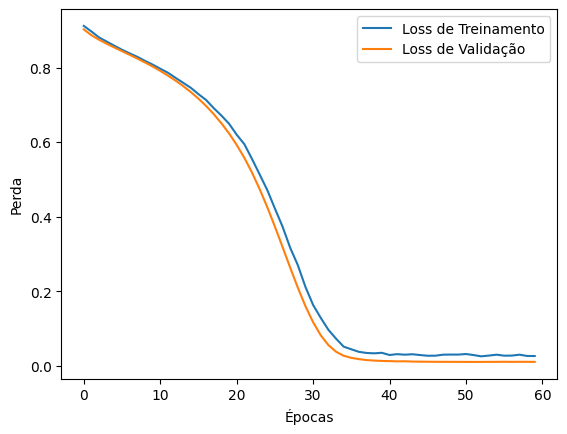

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0227
best_score_until_now 0.02269638702273369
Melhor solução encontrada até agora: [0.40772878]
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


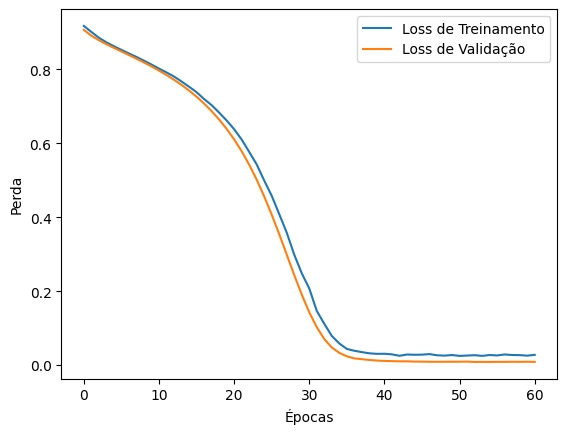

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0226
best_score_until_now 0.02255963534116745
Melhor solução encontrada até agora: [2.14639867]
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


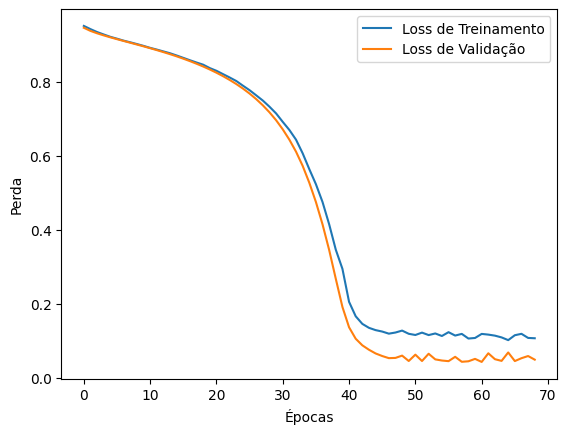

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


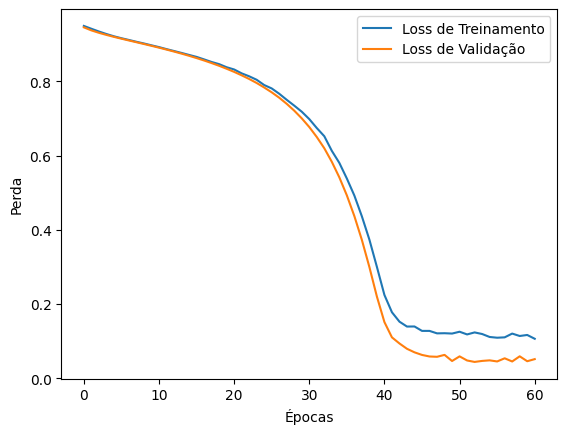

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0803
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


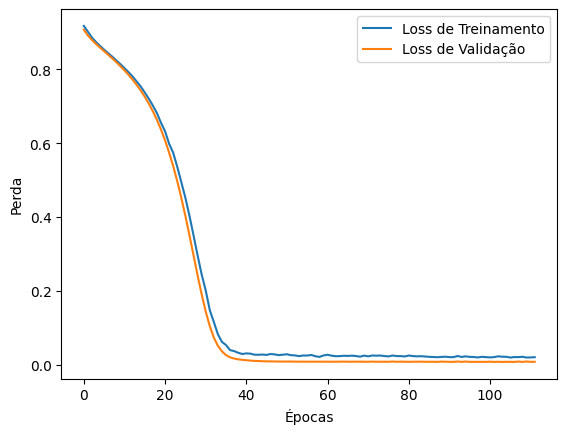

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0229
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


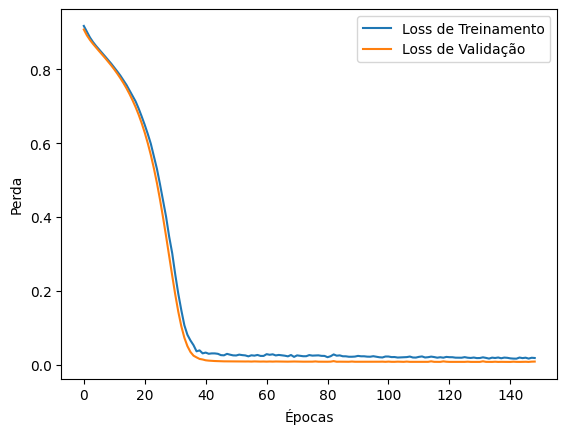

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0235
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


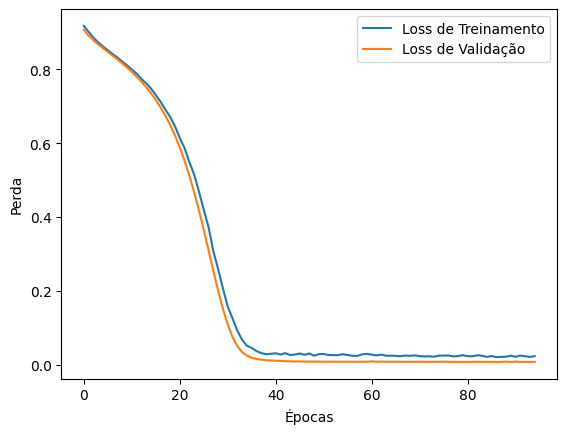

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0227
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


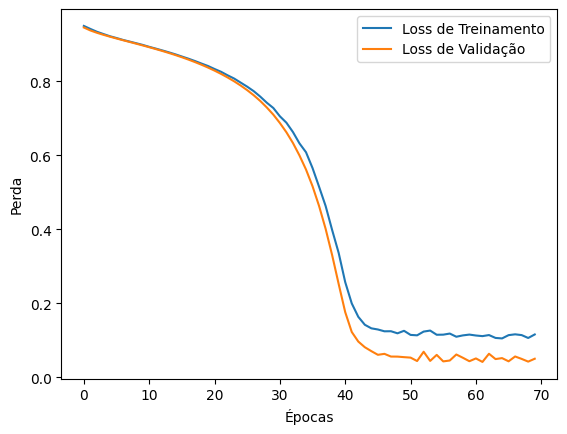

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


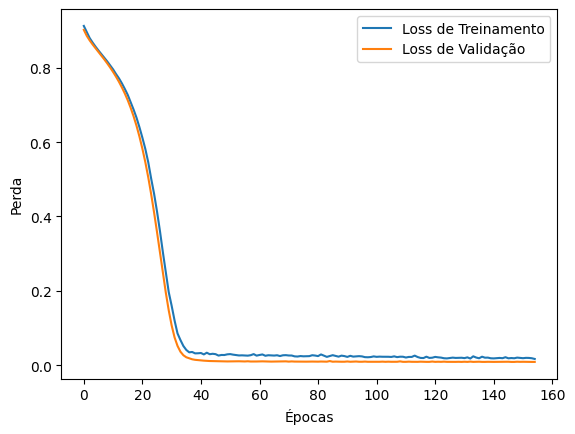

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0231
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


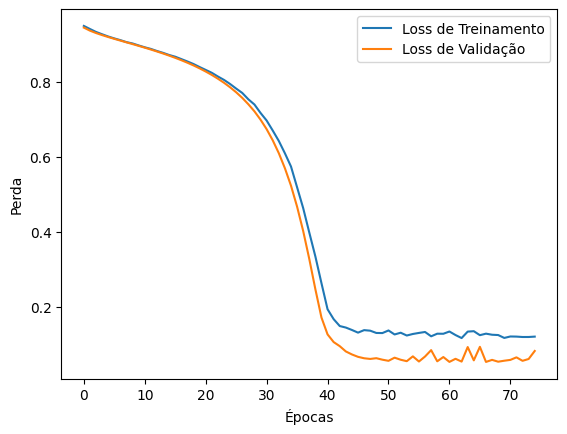

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0853
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


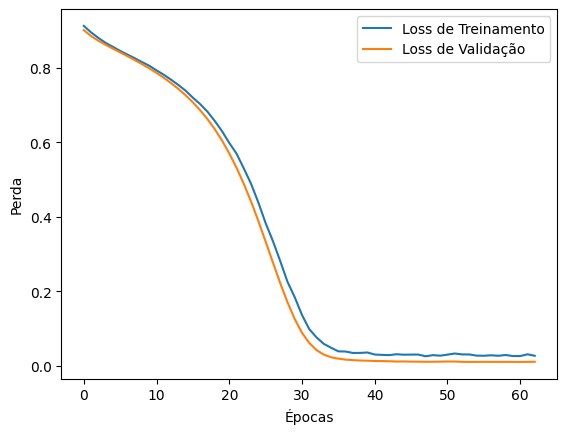

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0219
best_score_until_now 0.021921638399362564
Melhor solução encontrada até agora: [0.94931787]
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


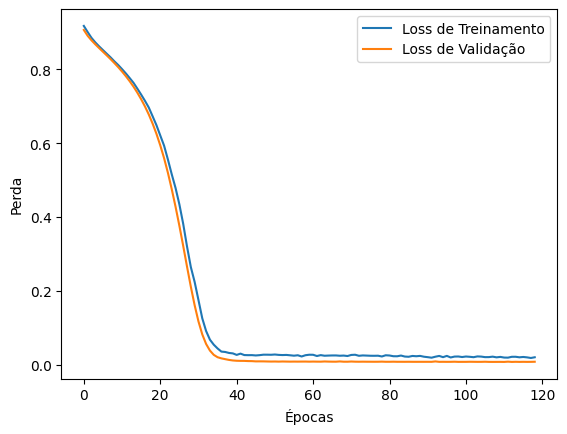

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0231
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


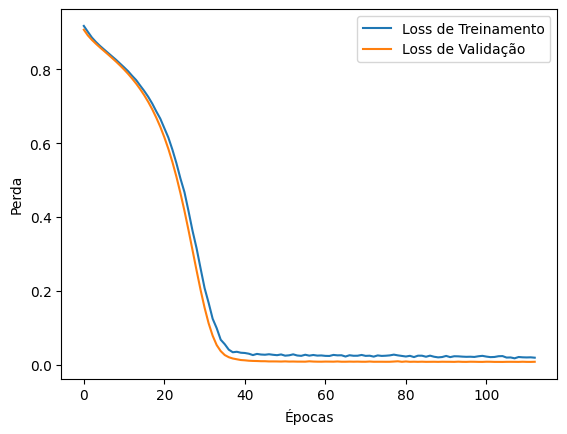

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0228
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


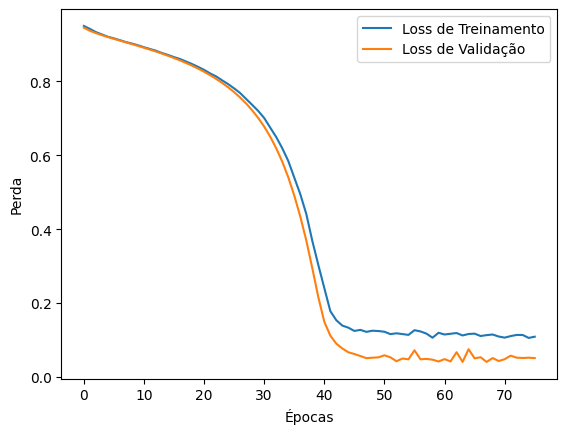

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0752
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


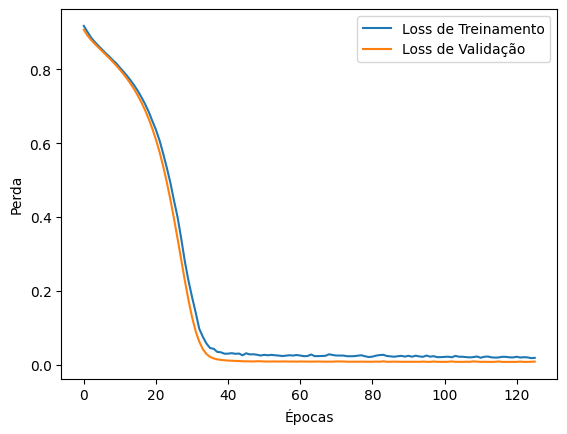

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


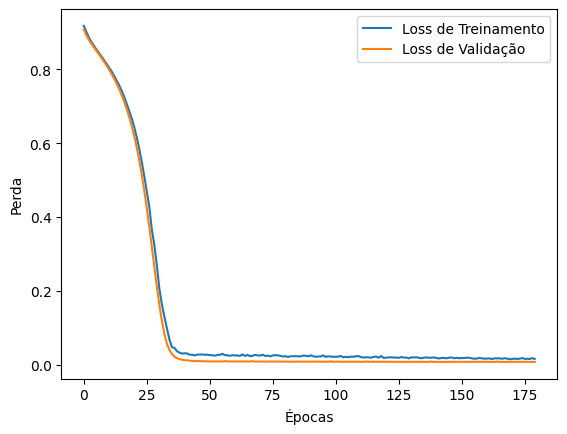

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0240
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


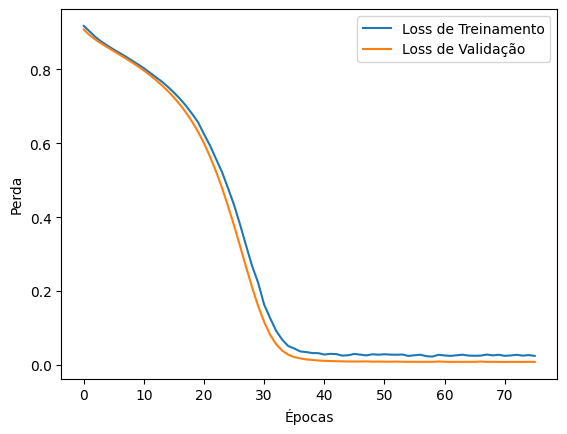

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0226
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


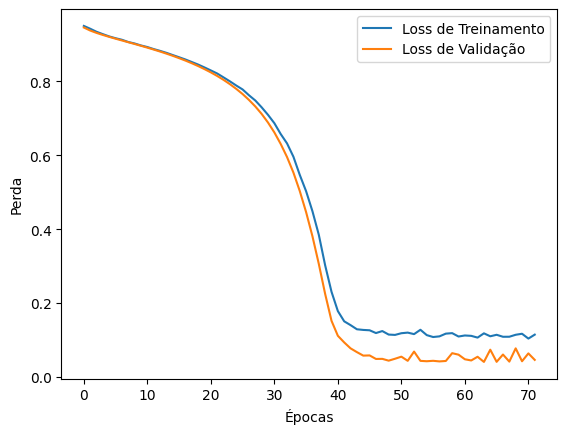

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0743
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


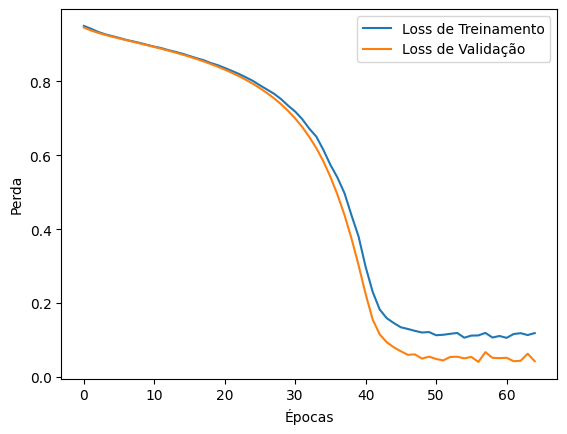

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0759
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


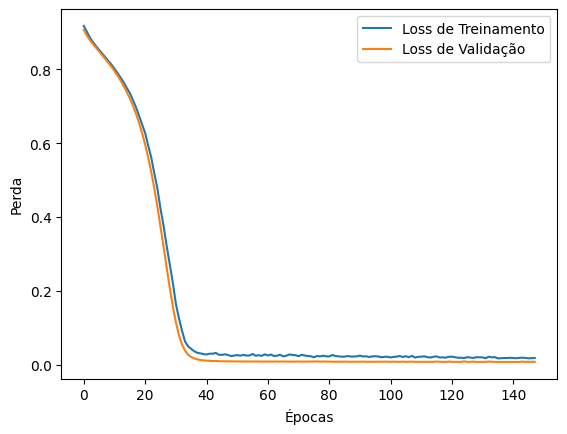

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0235
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


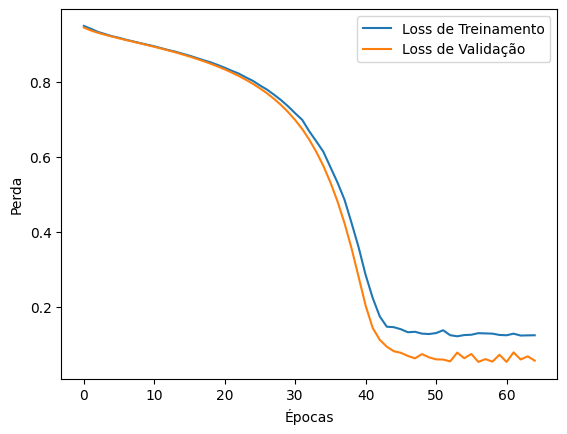

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0855
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


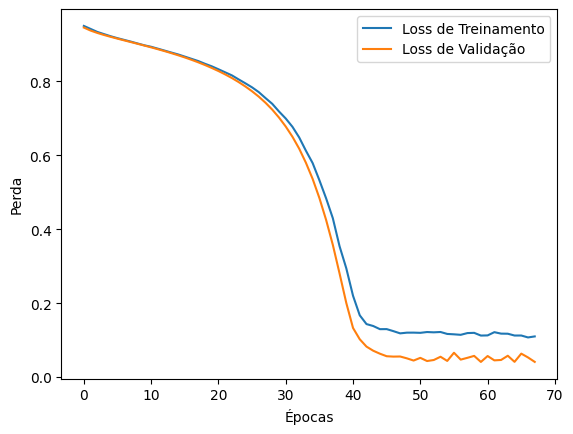

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


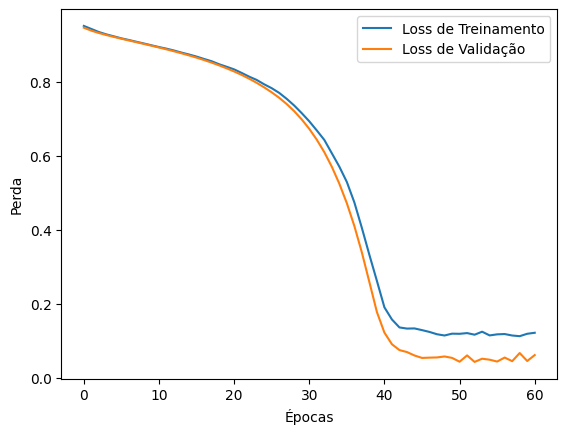

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


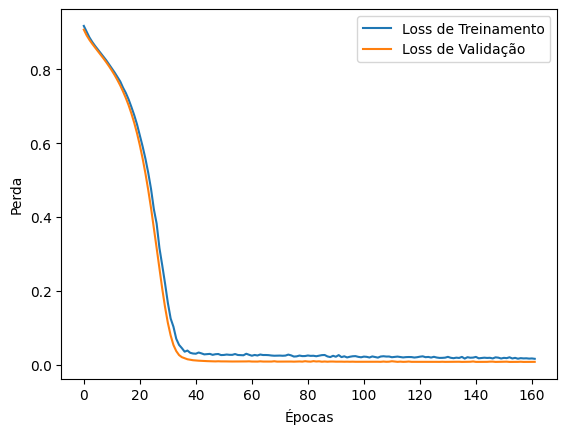

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0237
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


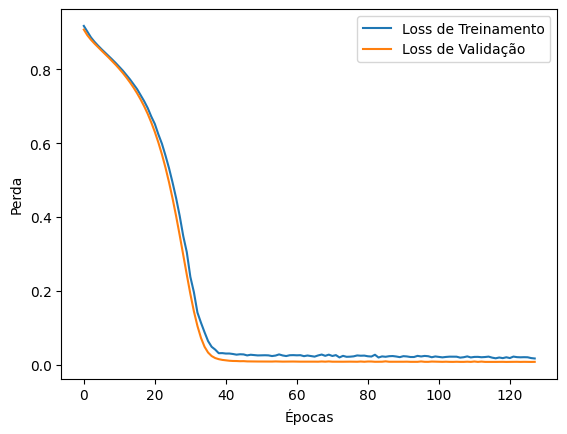

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0231
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


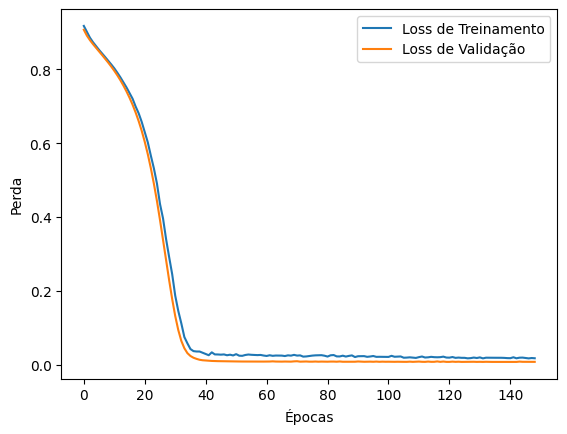

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0233
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


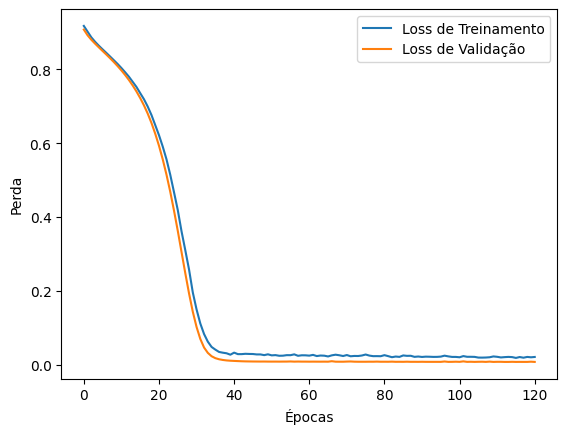

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


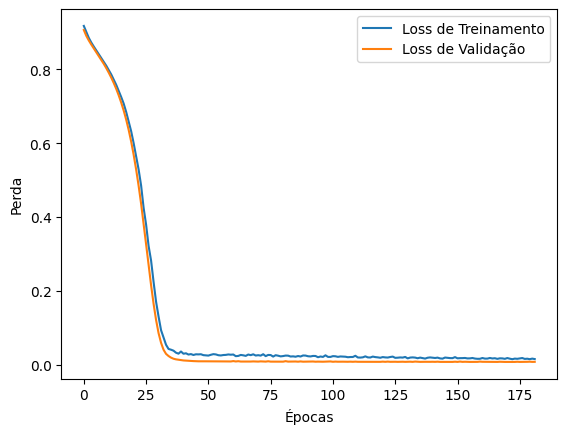

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0239
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


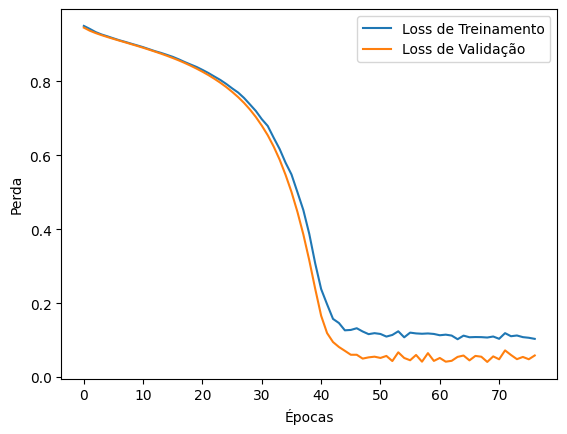

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0771
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


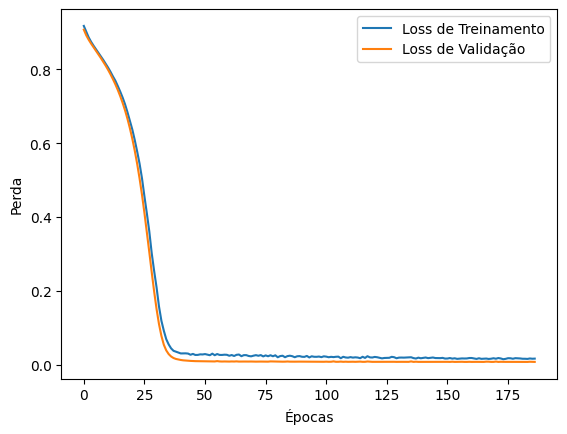

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0240
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


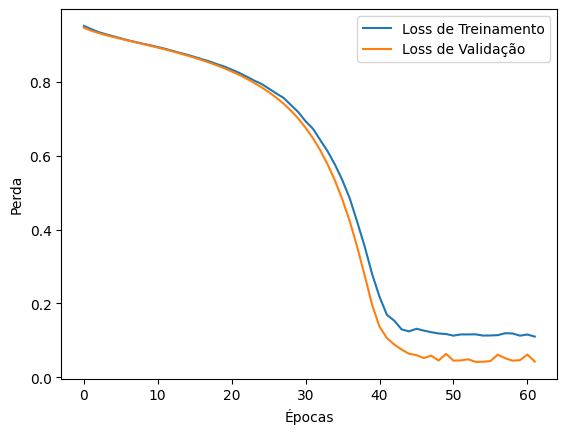

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0774
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


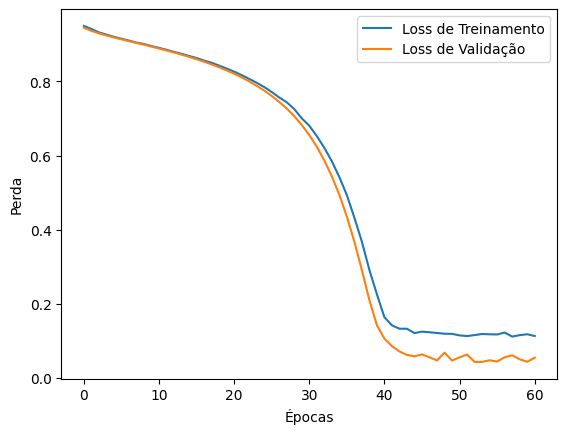

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


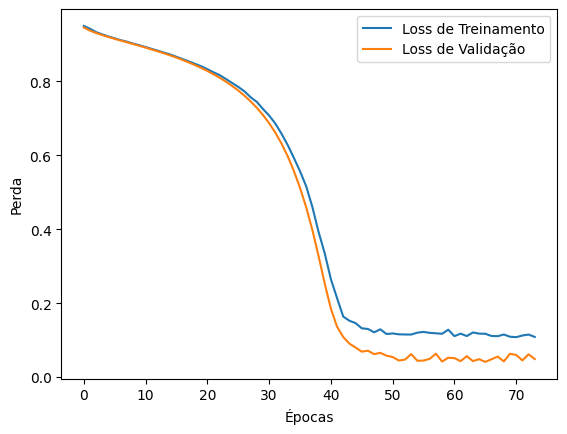

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0744
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


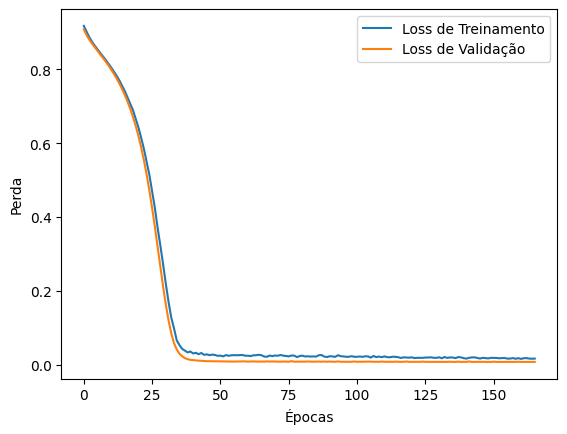

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0238
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


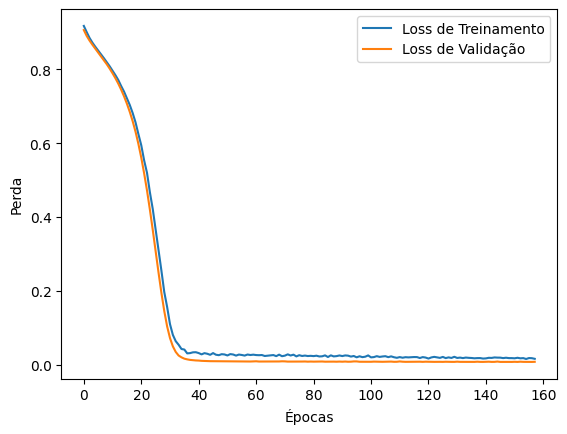

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0236
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


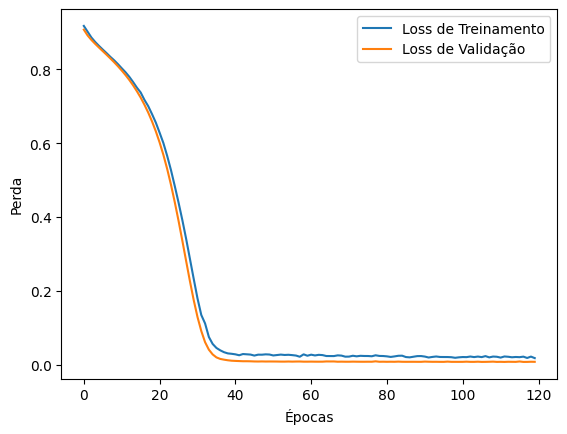

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


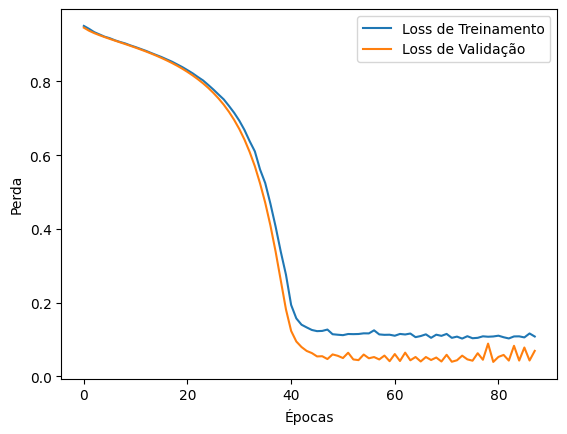

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0761
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


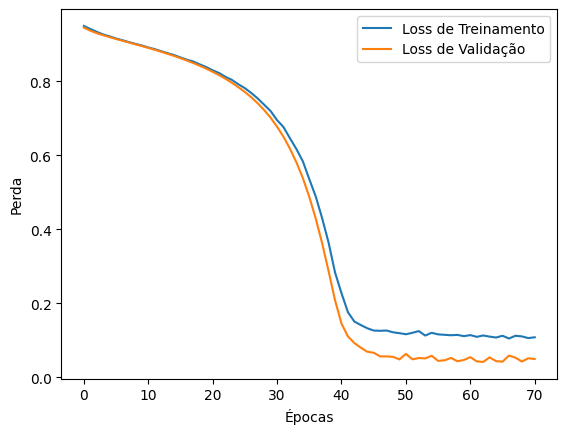

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0754
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


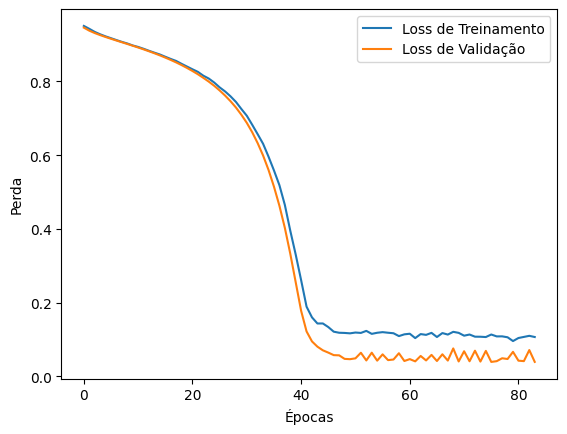

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


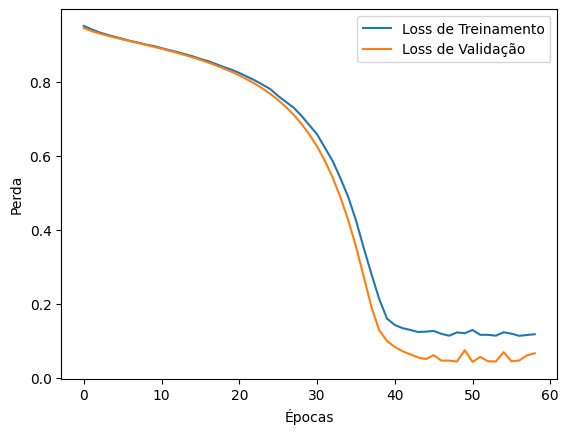

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0775
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


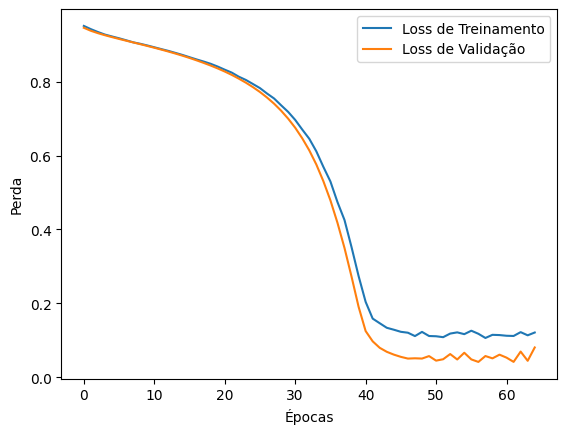

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0743
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


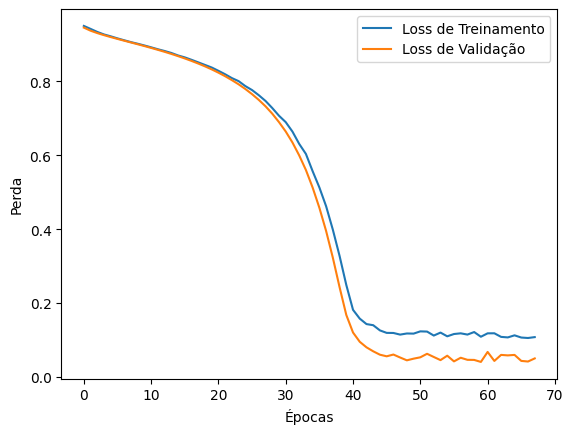

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


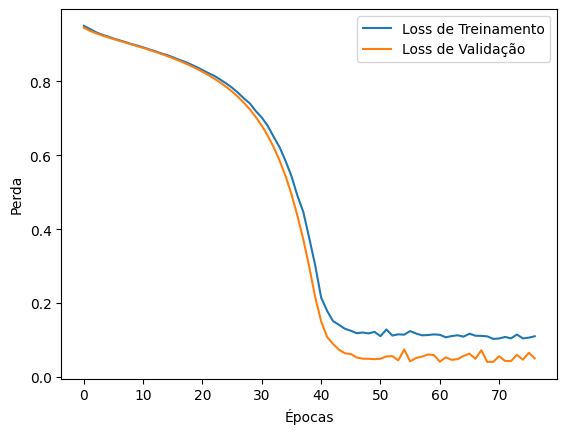

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0765
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


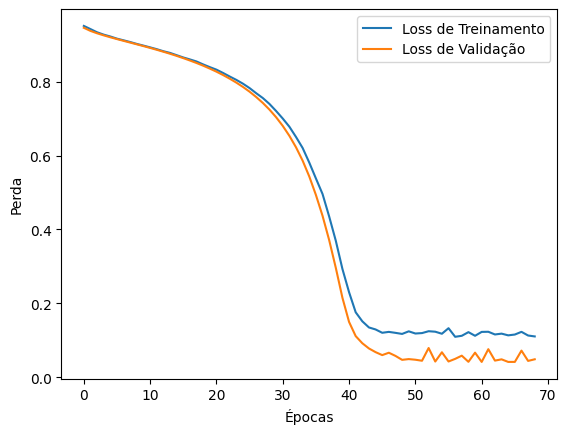

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


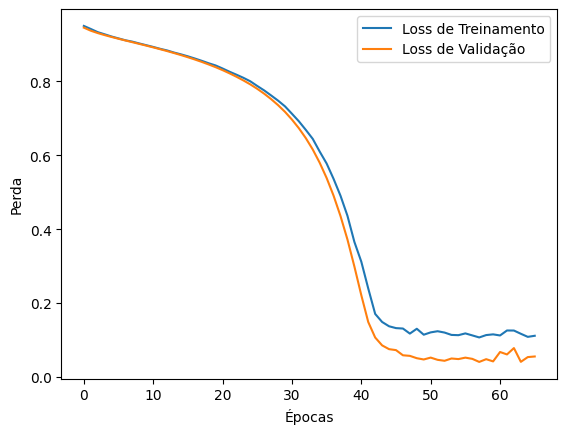

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0755
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


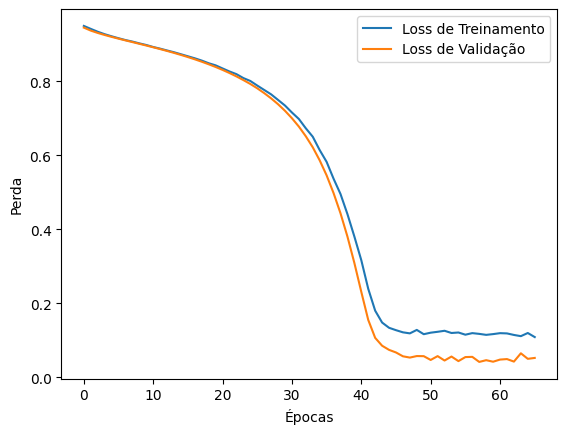

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


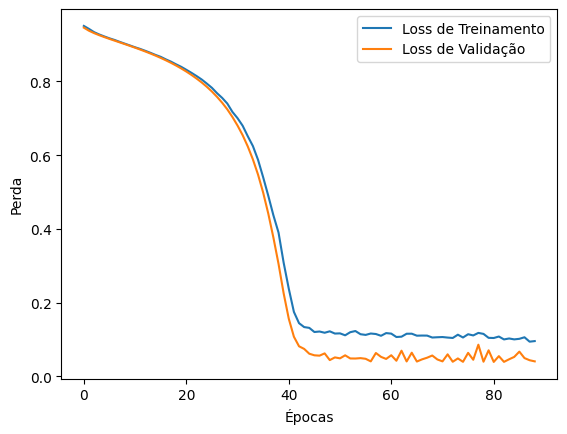

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0776
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


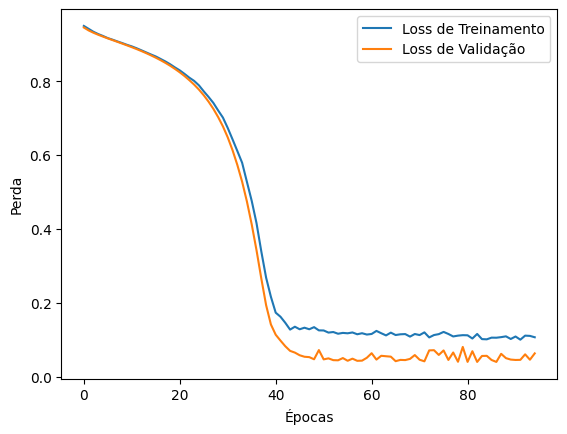

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0769
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


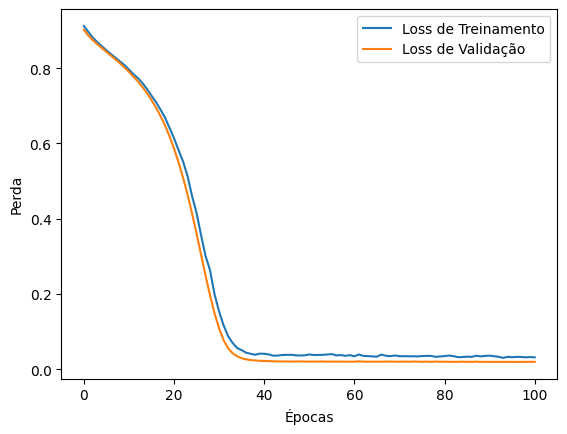

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0335
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


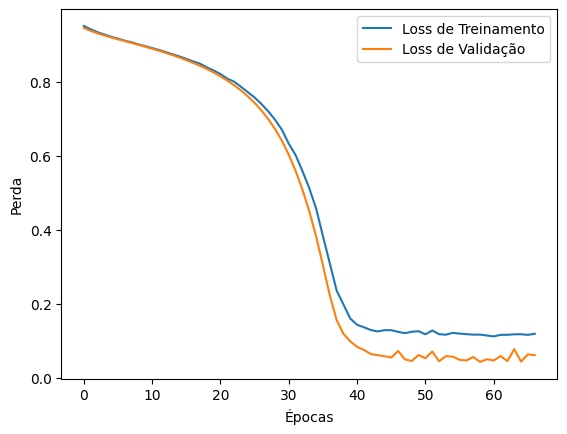

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


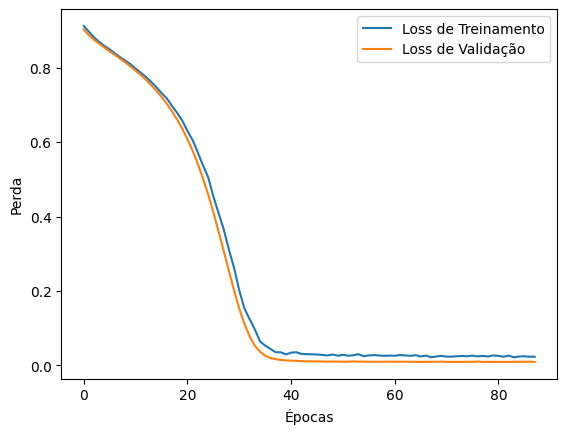

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0226
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


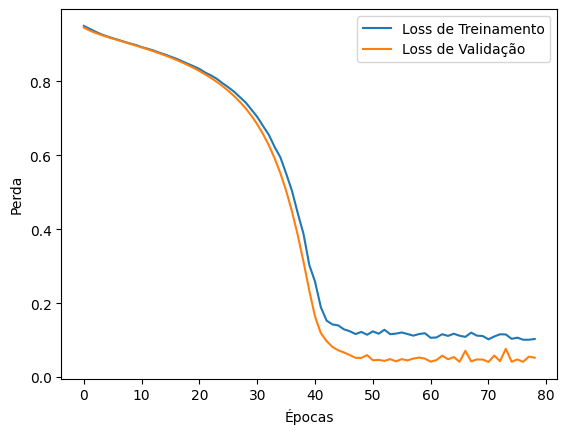

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0751
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


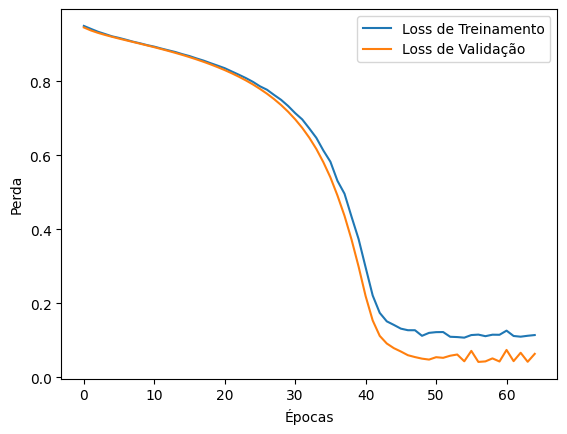

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0772
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


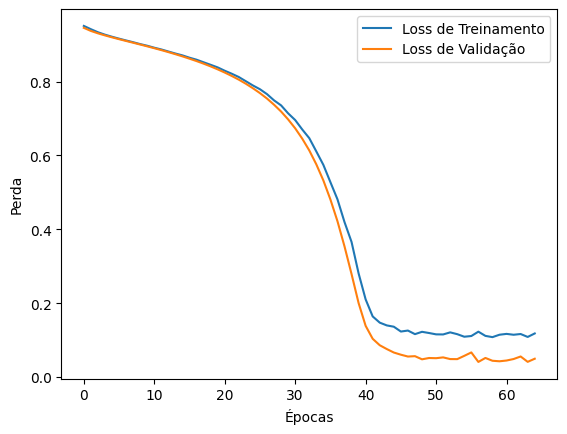

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0766
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


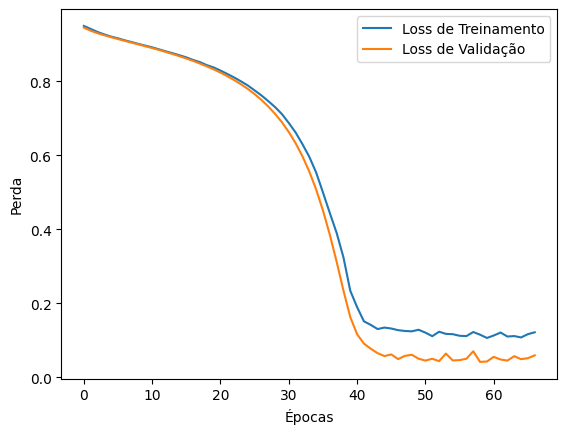

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0762
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


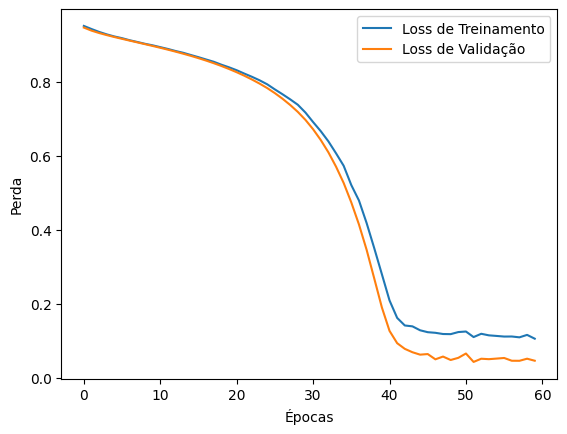

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0776
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


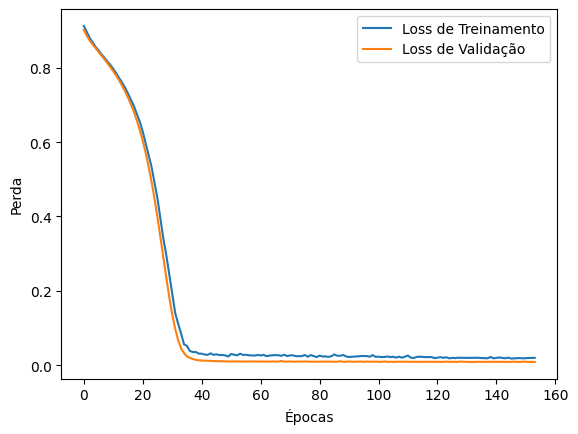

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


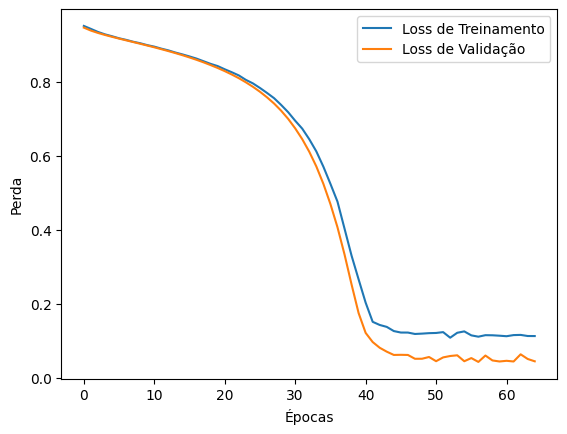

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0777
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


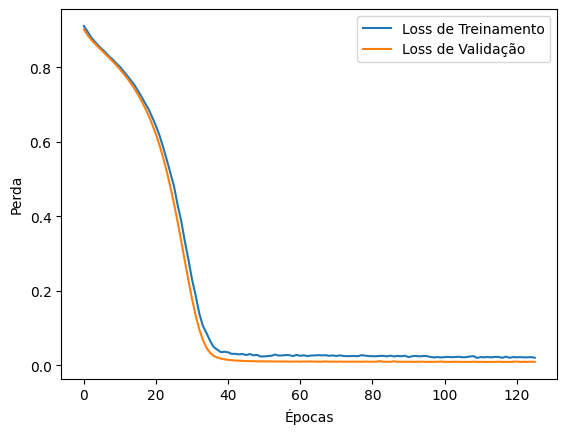

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


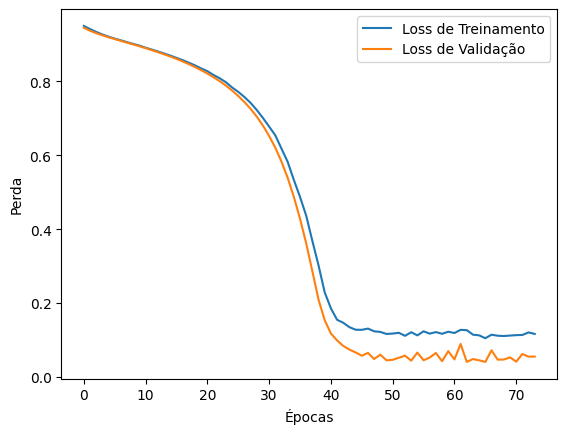

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0748
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


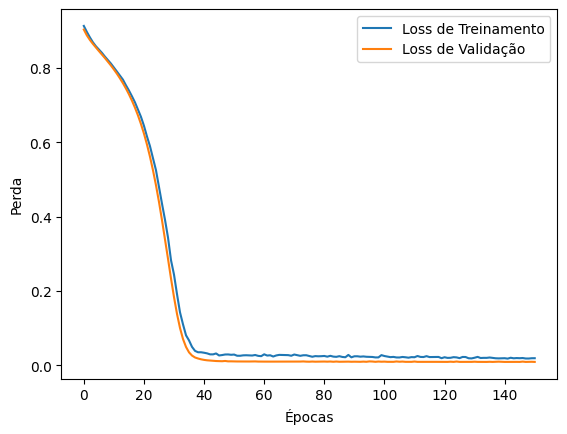

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0235
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


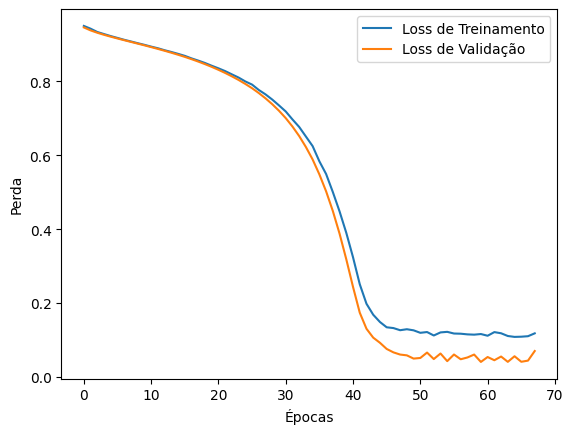

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


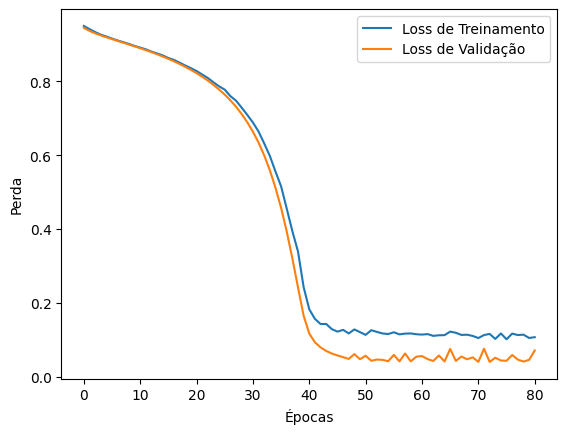

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0747
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


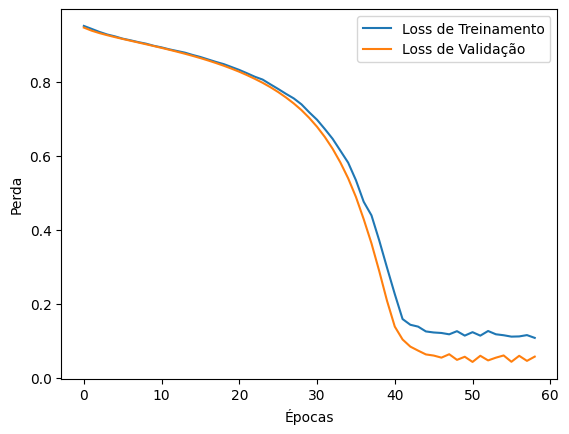

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0771
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


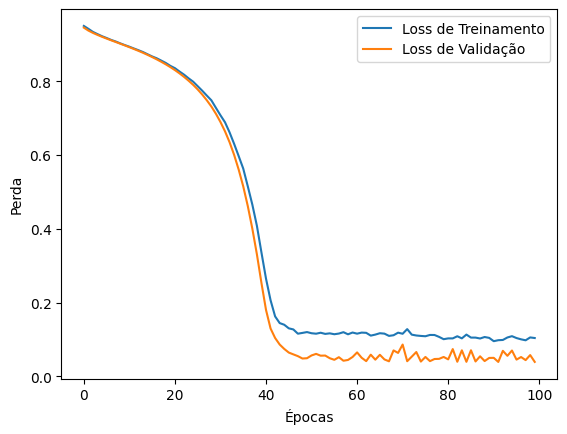

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


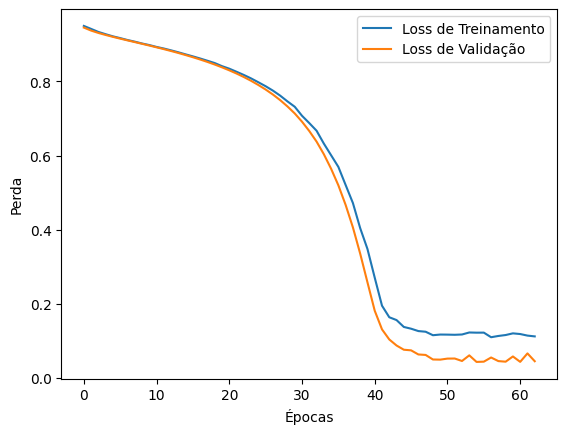

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0776
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


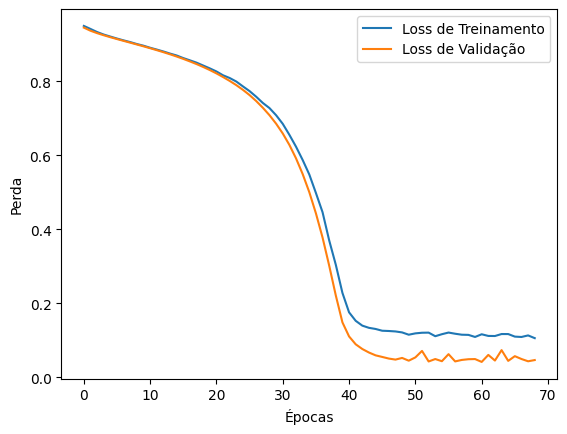

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0763
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


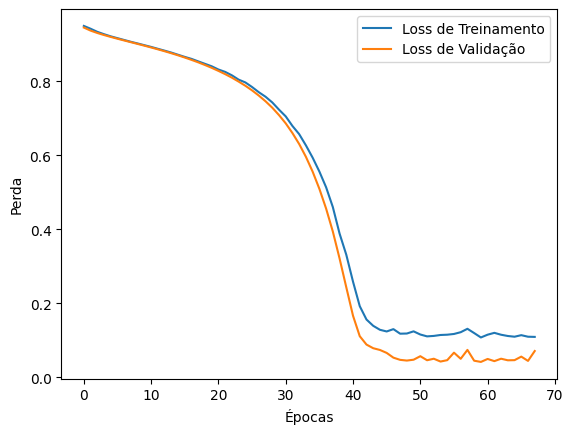

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


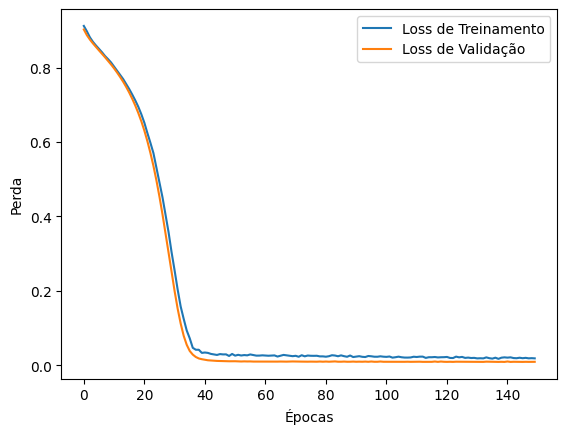

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0234
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


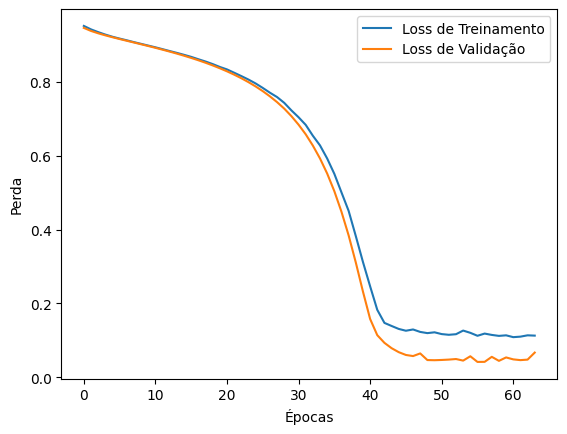

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0755
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


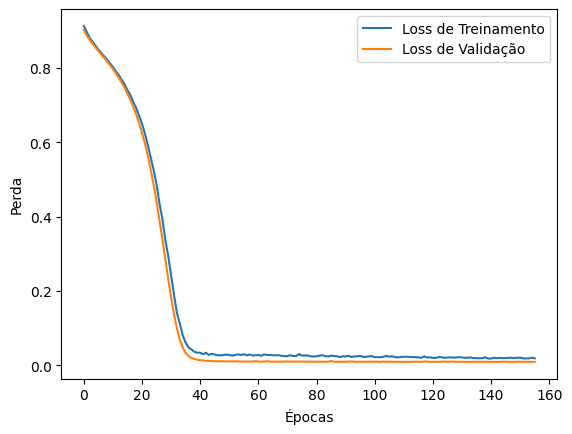

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


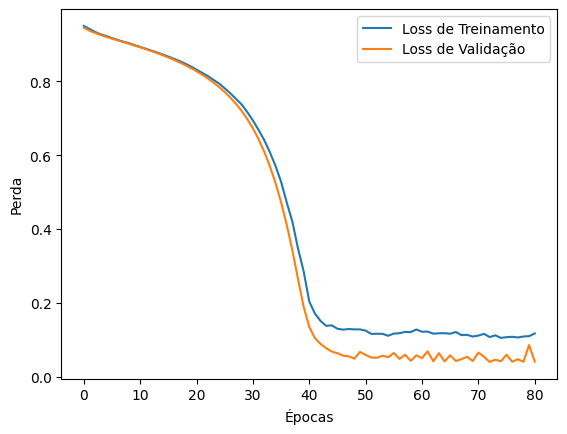

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0773
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


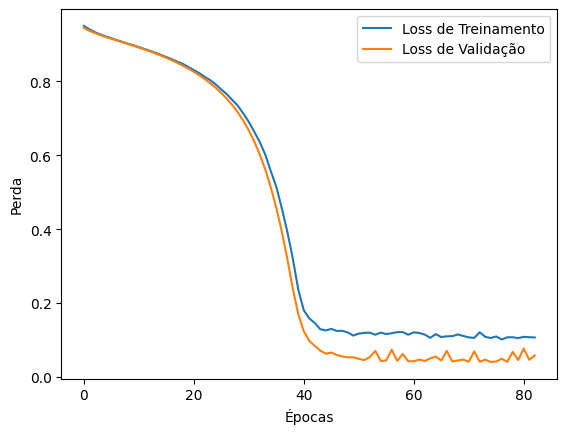

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0755
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


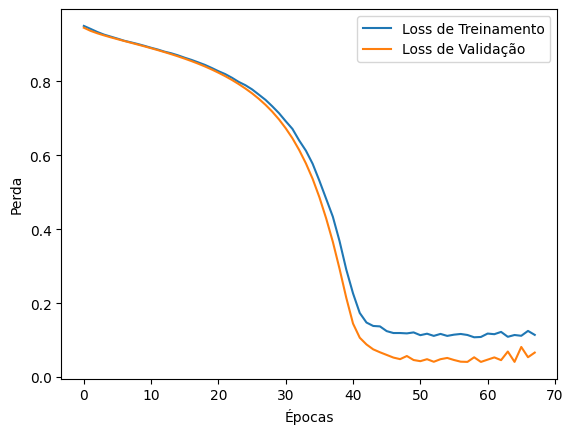

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0752
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


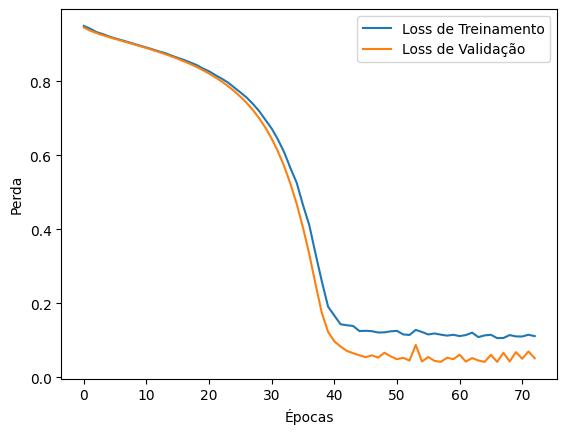

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0750
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


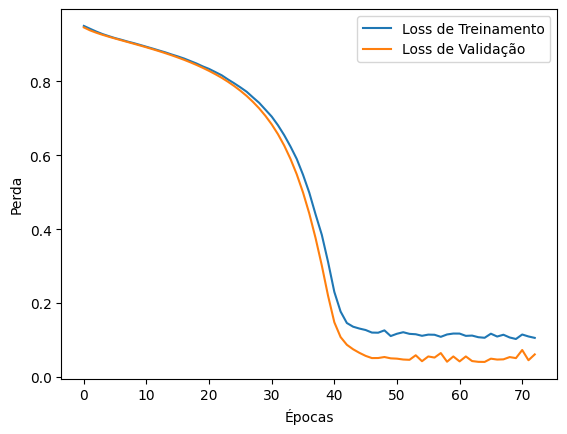

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0759
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


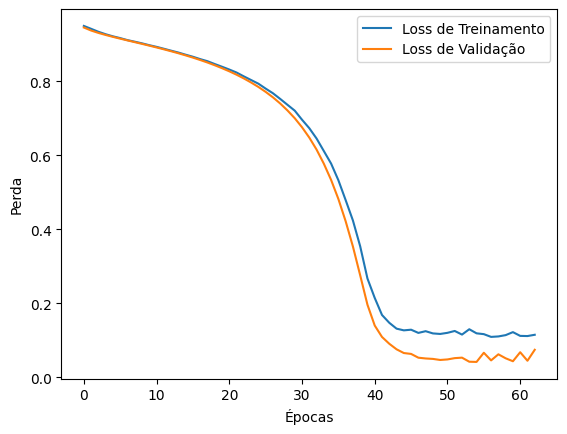

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


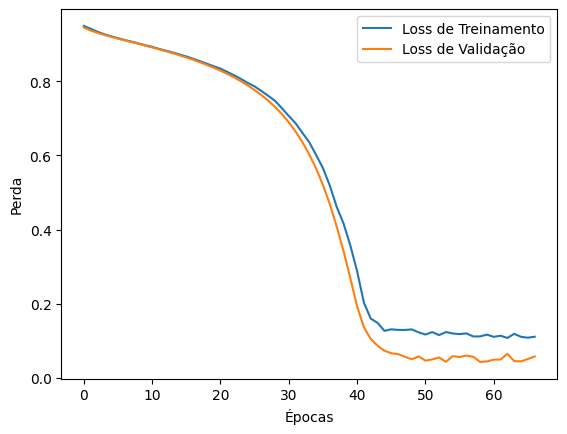

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0767
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


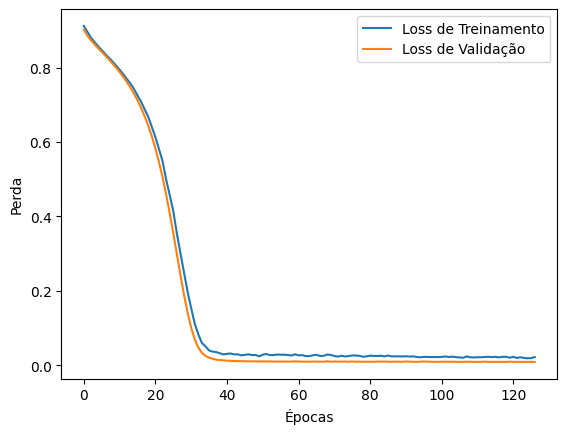

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0228
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


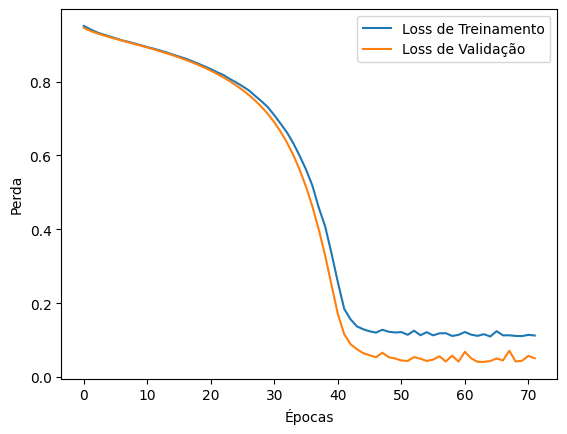

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


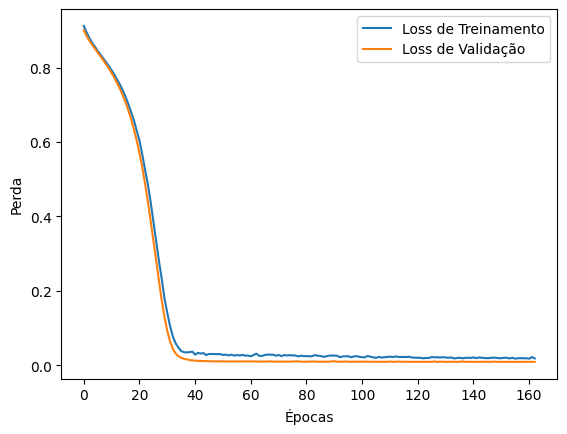

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0237
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


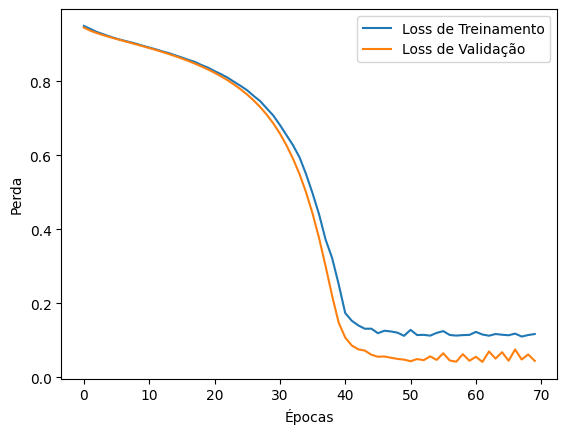

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0763
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


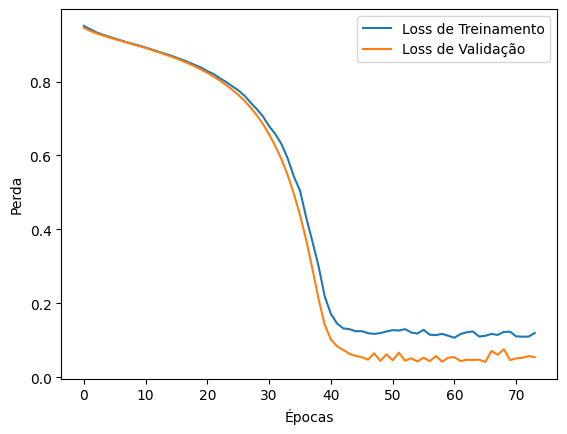

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


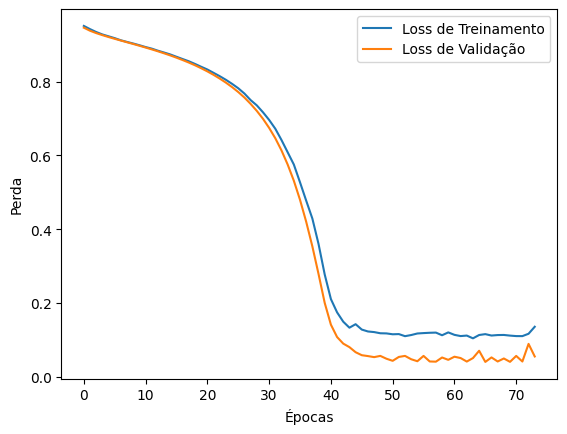

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


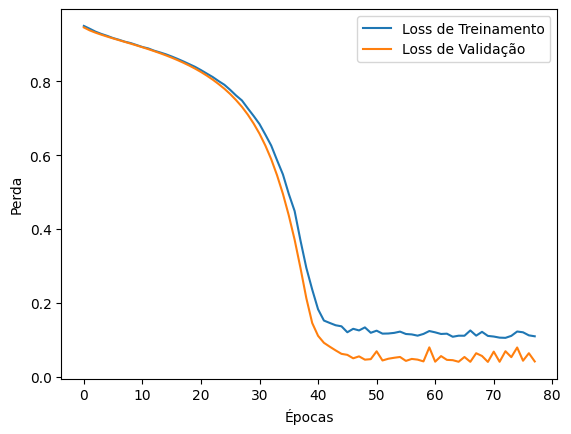

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0762
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


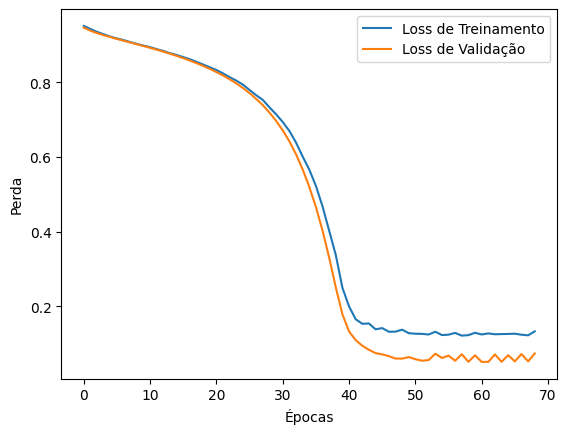

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0850
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


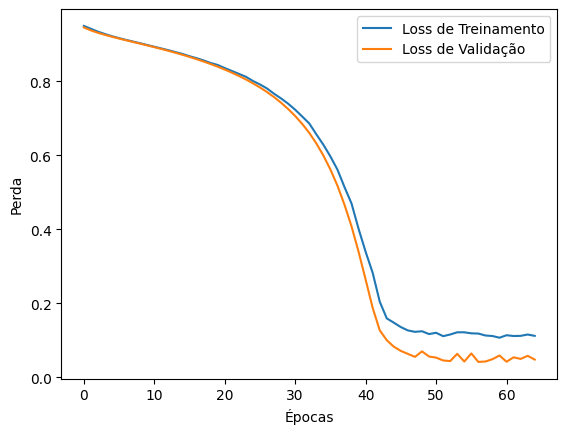

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


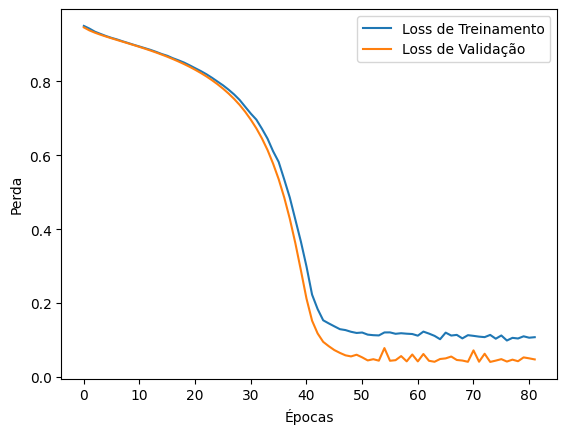

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0768
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


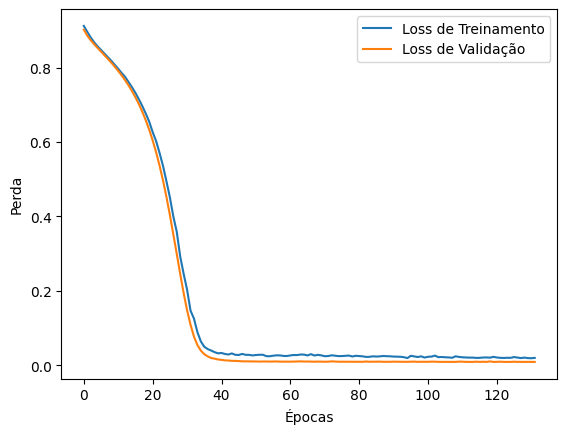

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


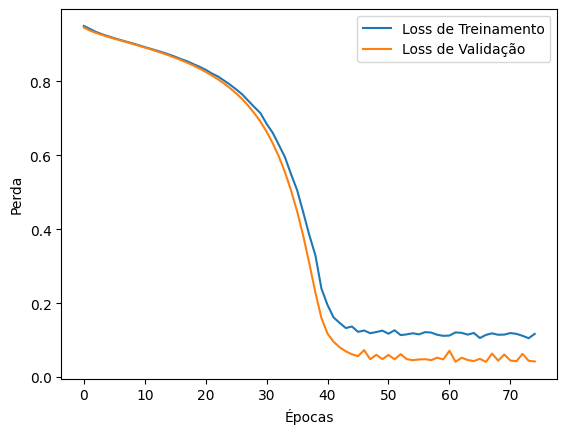

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


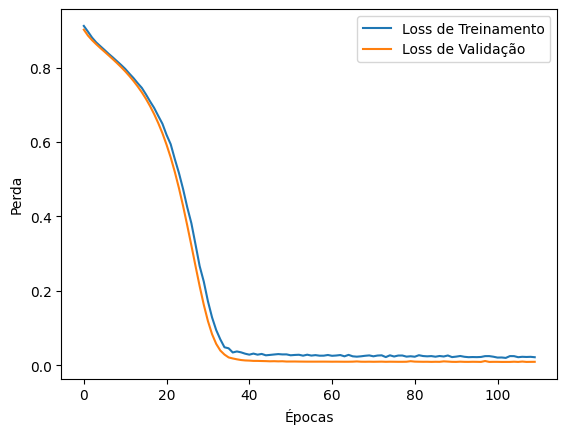

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0225
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


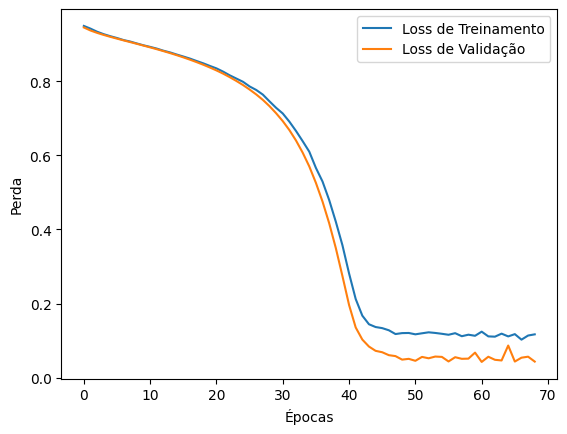

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0754
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


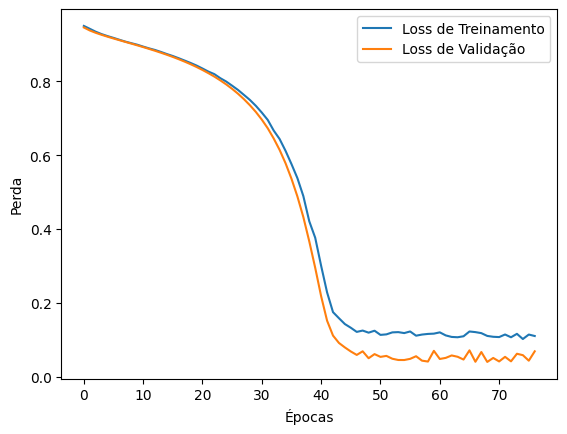

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


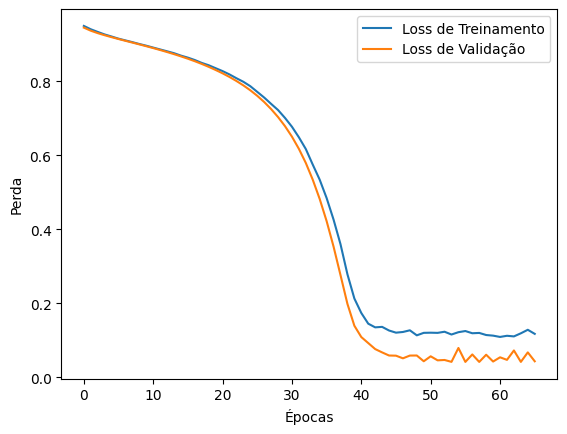

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


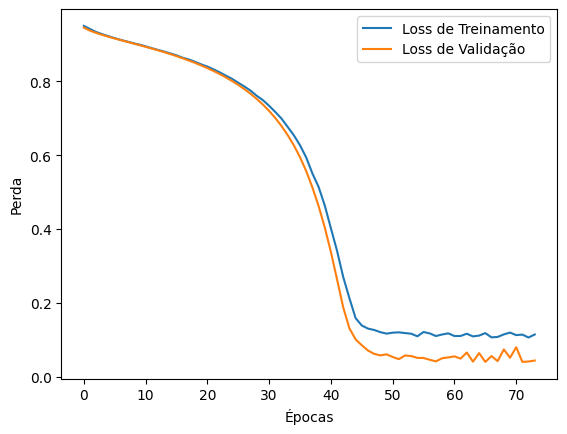

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0761
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


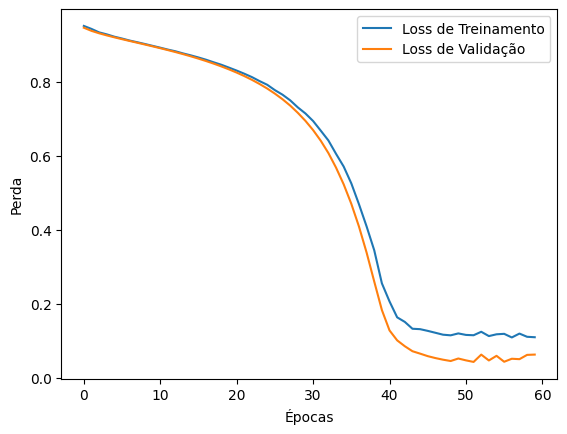

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0783
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


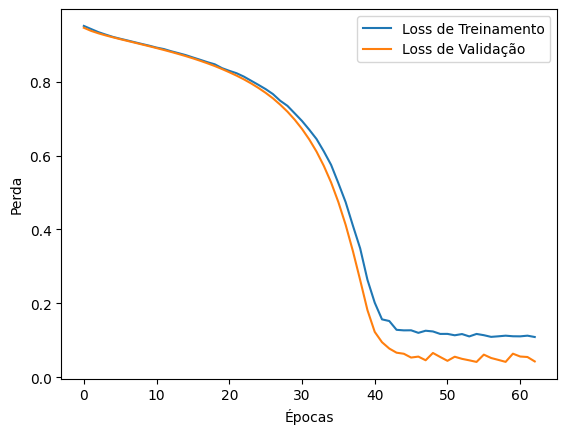

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


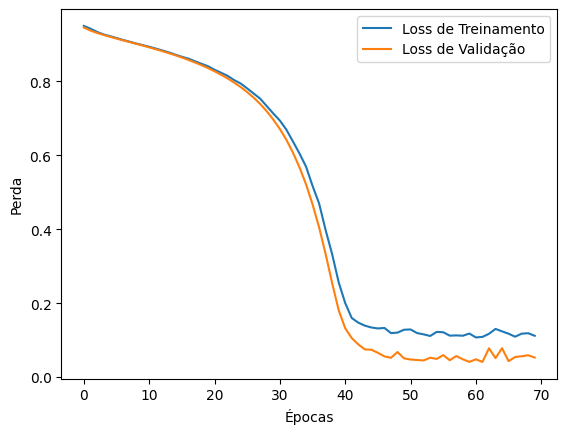

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0751
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


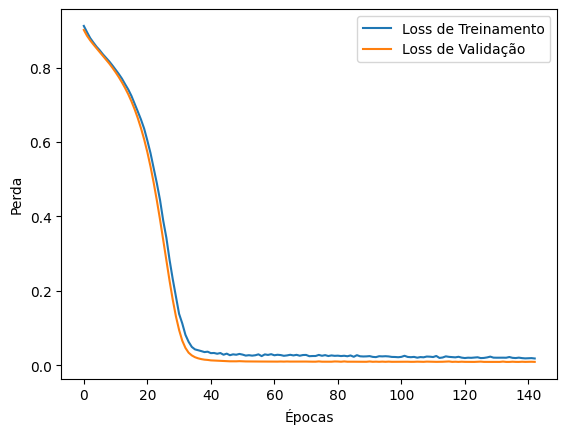

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


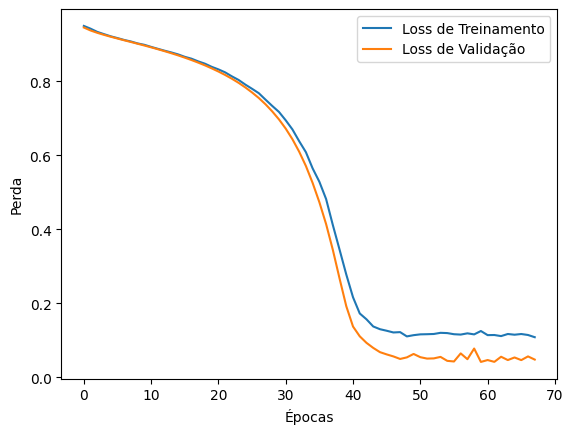

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


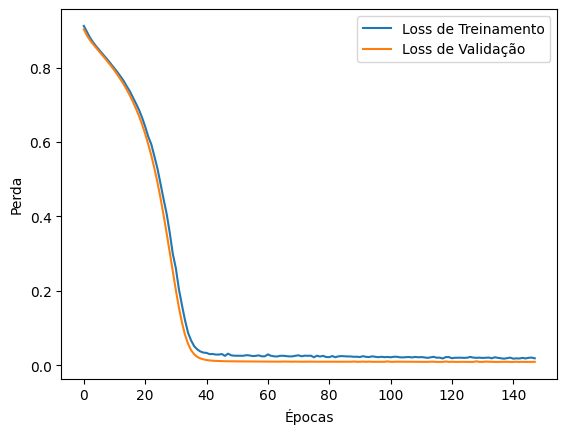

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0233
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


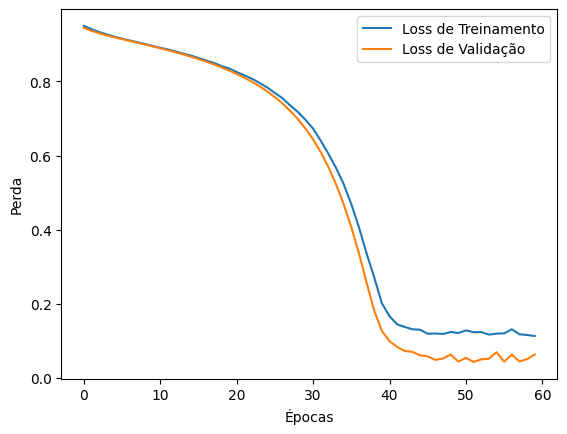

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


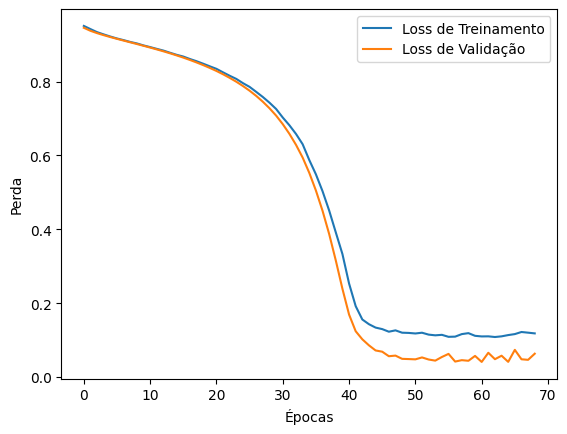

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


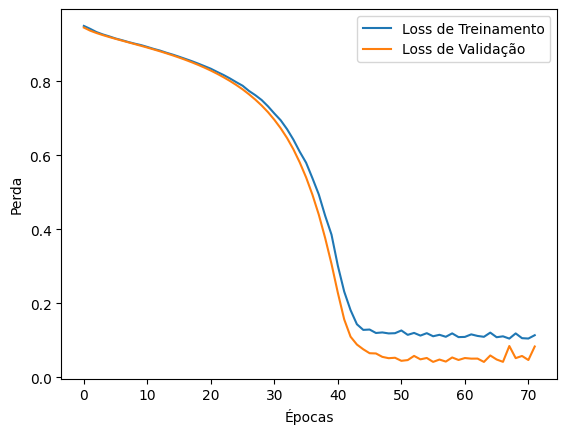

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0752
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


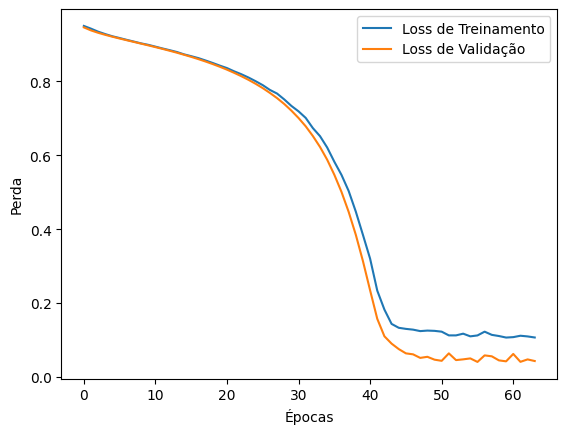

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


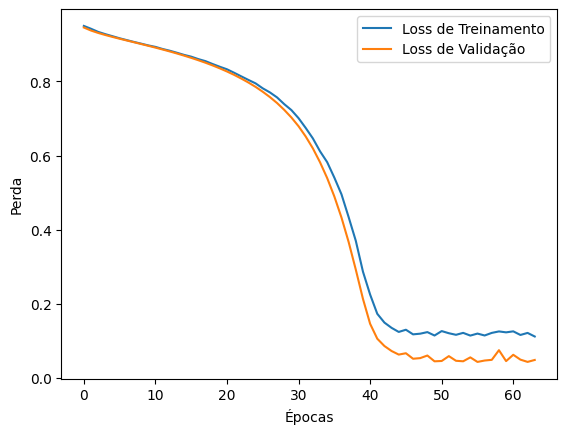

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


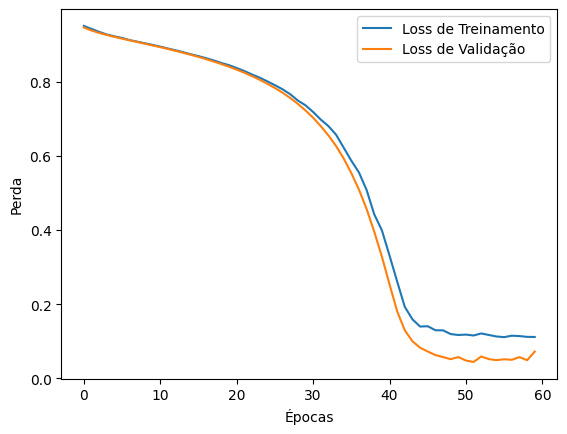

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0799
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


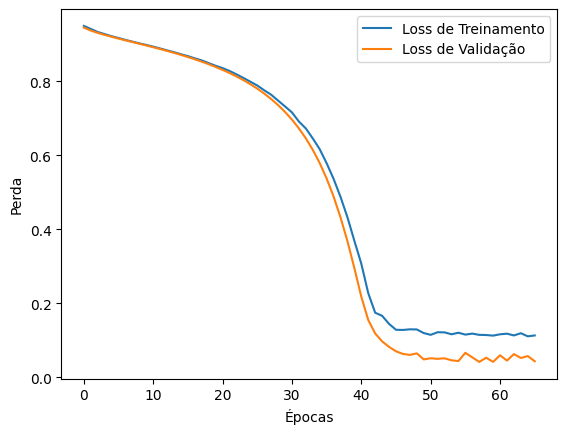

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


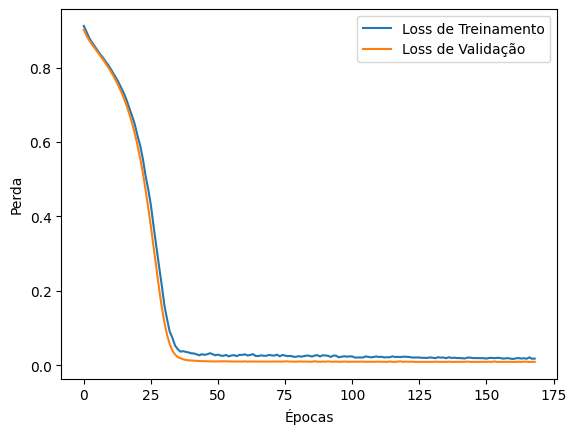

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0234
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


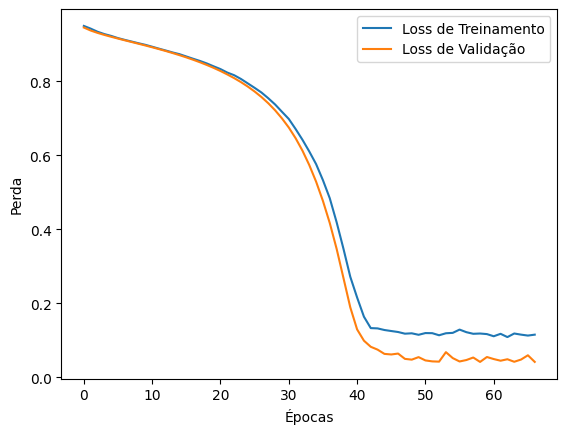

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


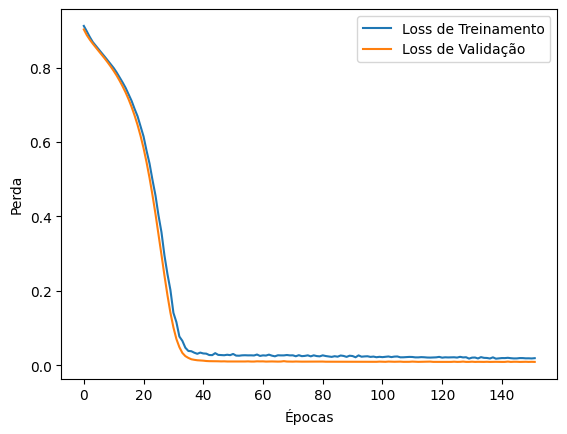

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


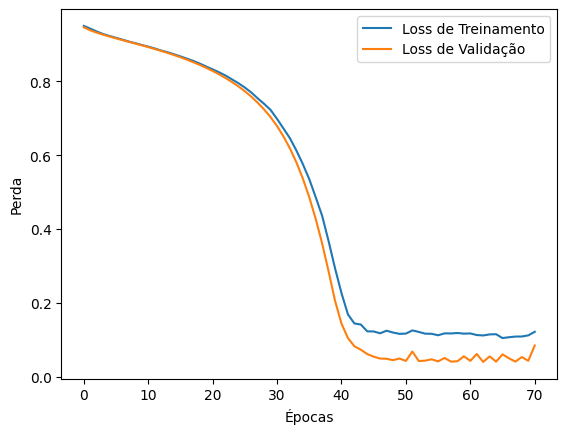

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


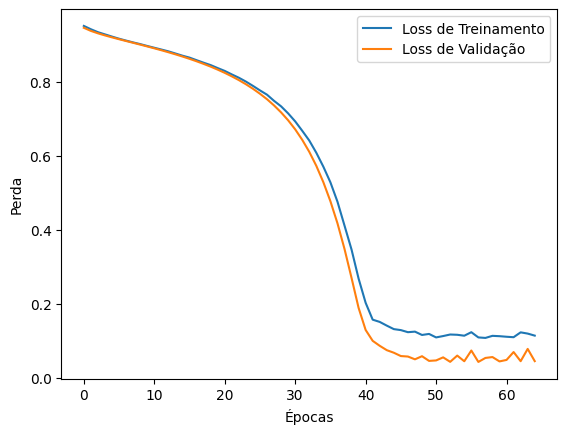

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


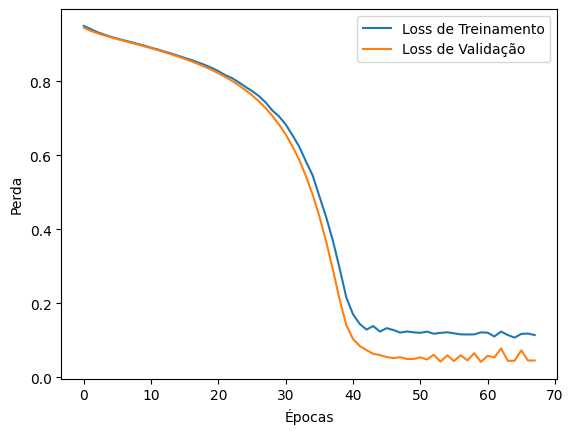

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0770
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


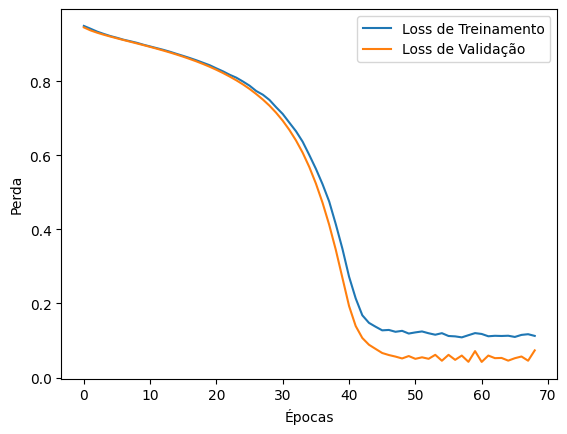

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


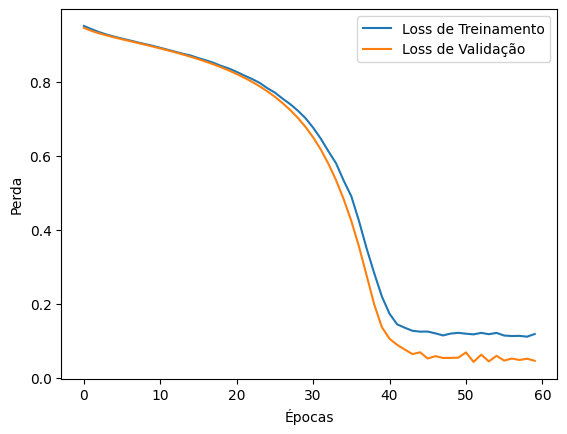

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0766
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


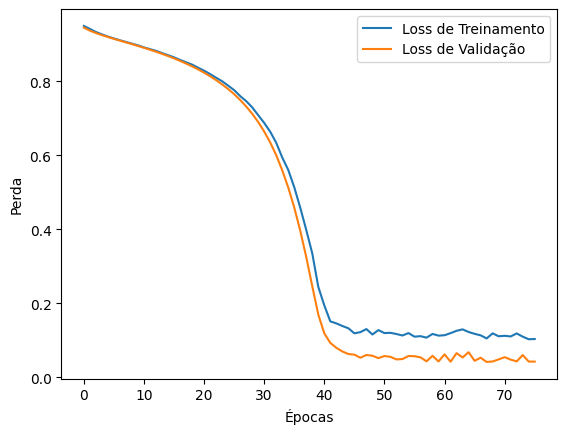

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


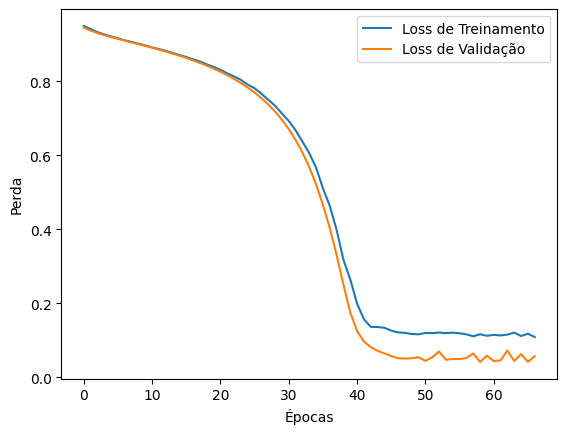

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0748
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


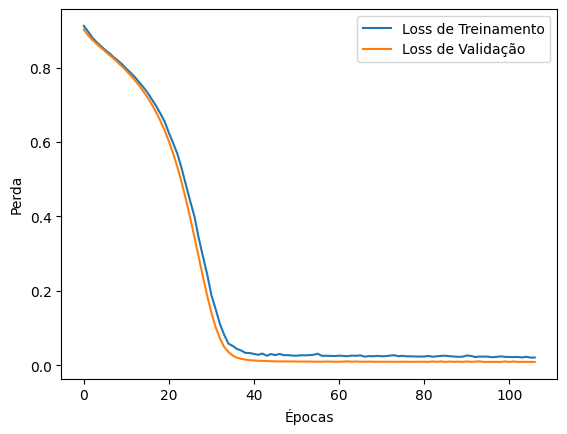

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0227
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


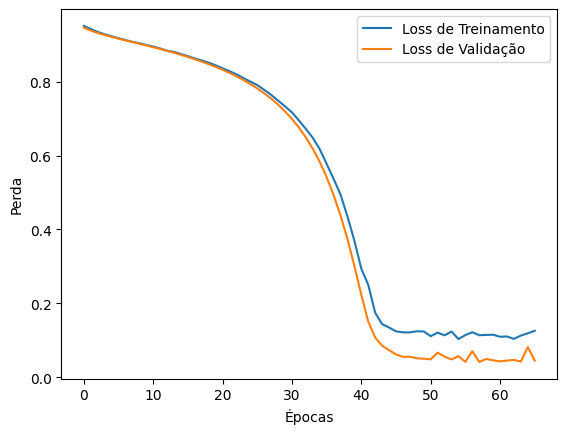

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0749
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


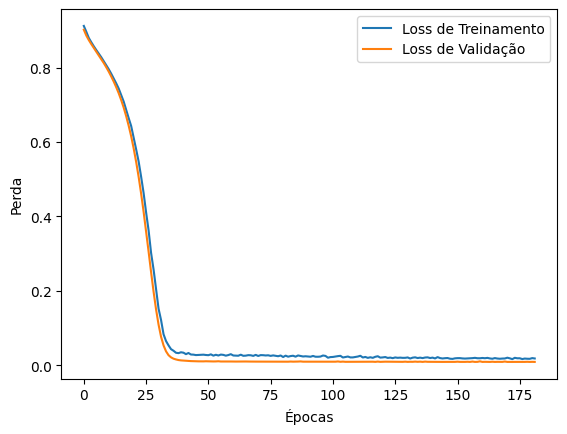

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0238
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


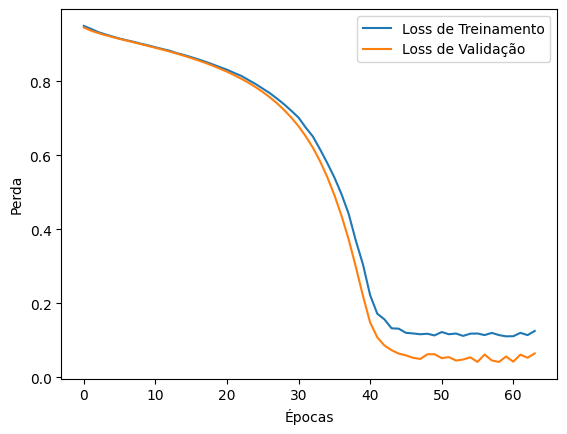

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0761
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


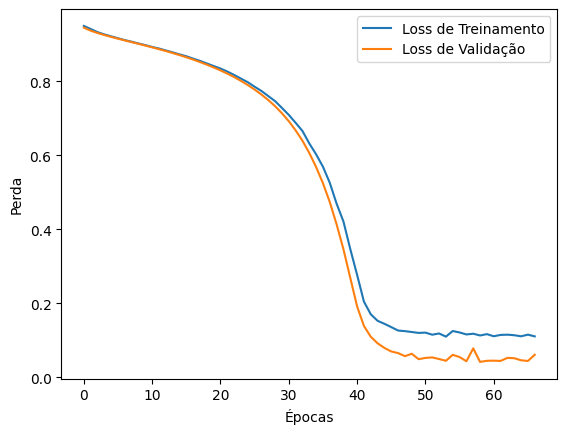

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


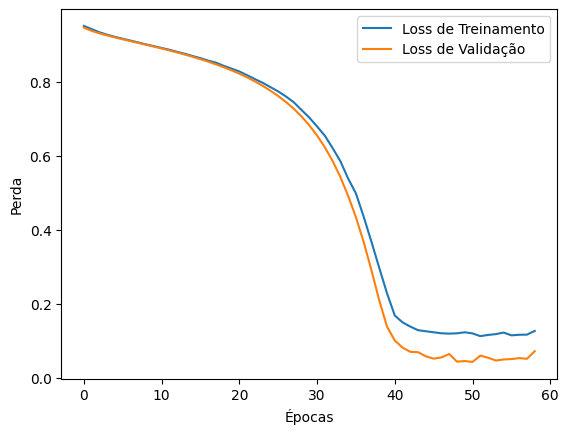

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0762
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


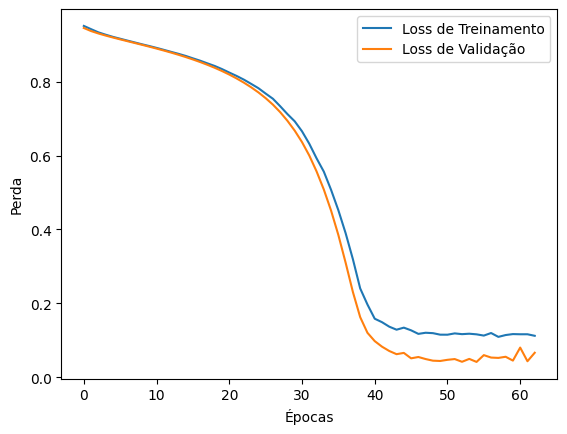

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0761
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


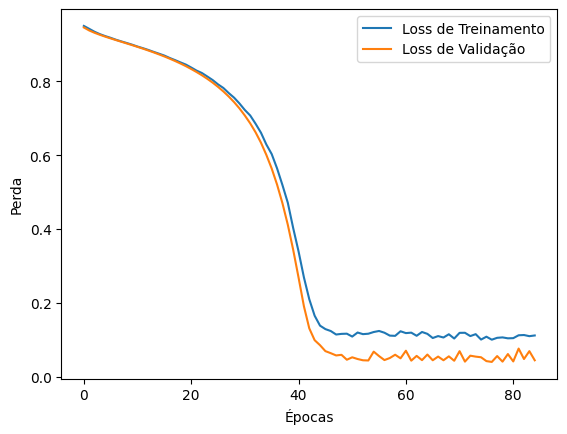

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0768
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


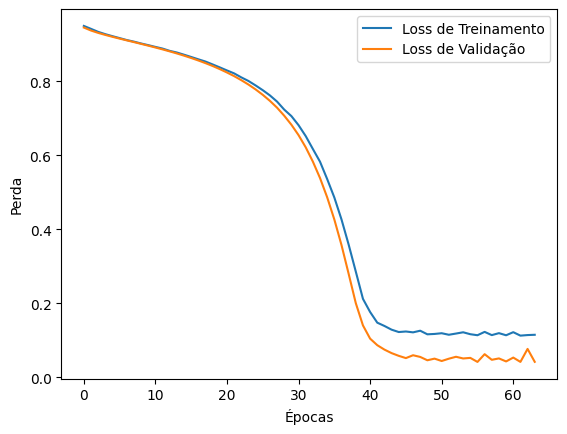

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0775
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


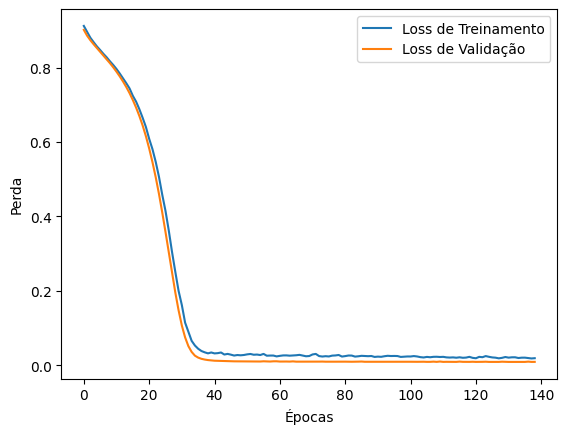

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0228
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


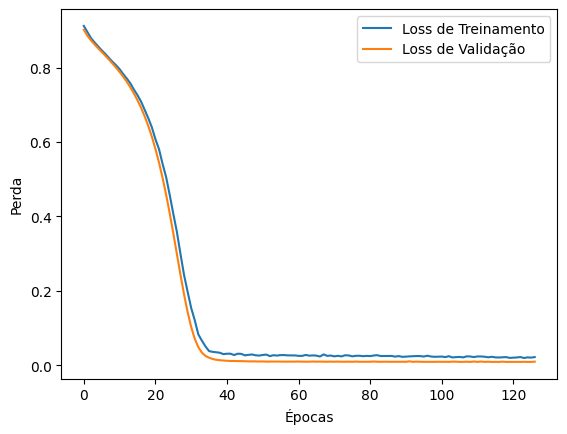

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0226
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


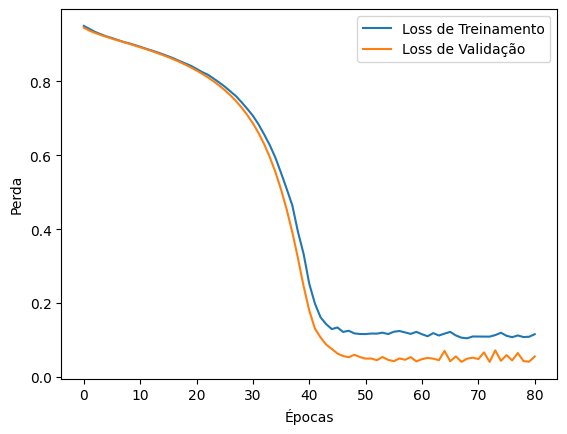

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


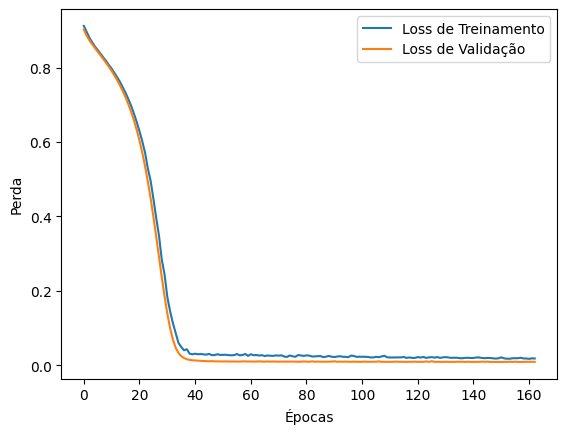

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0238
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


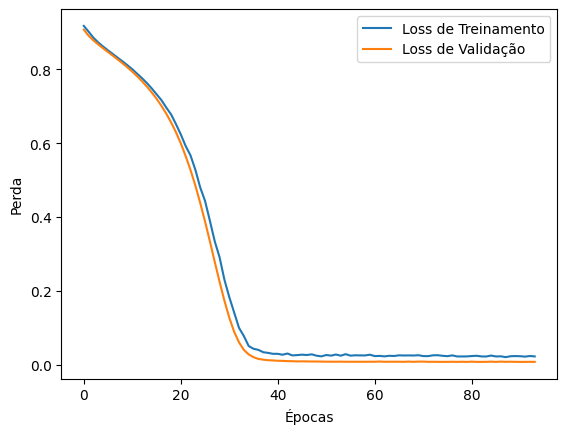

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0227
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


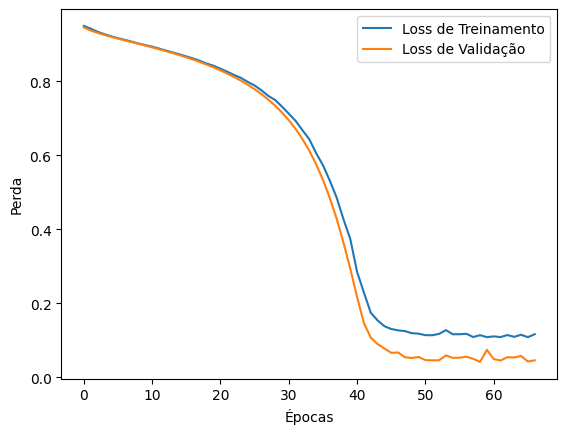

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0747
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


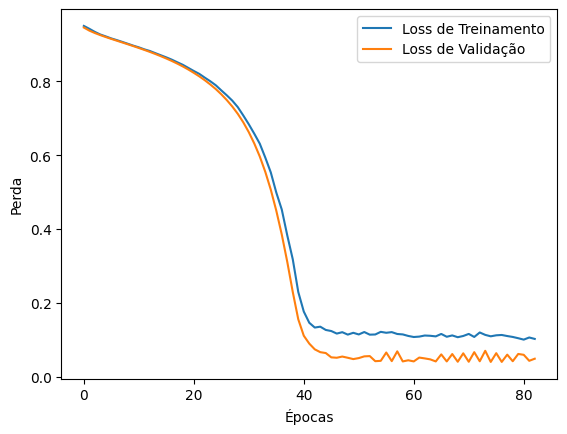

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0763
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


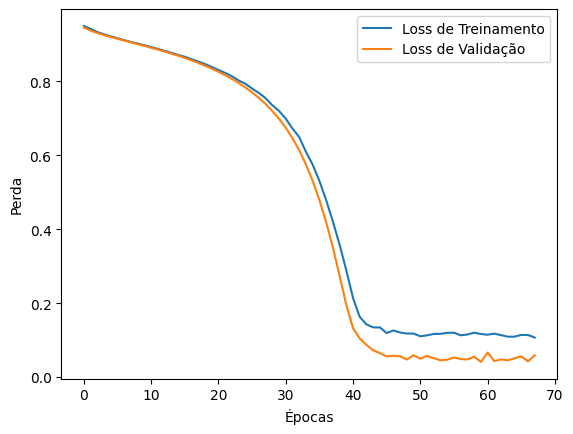

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0754
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


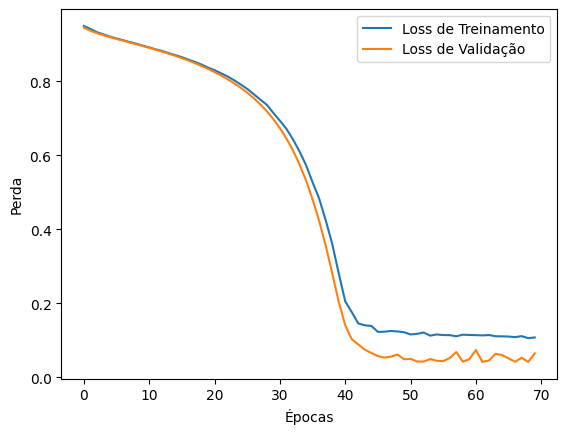

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0765
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


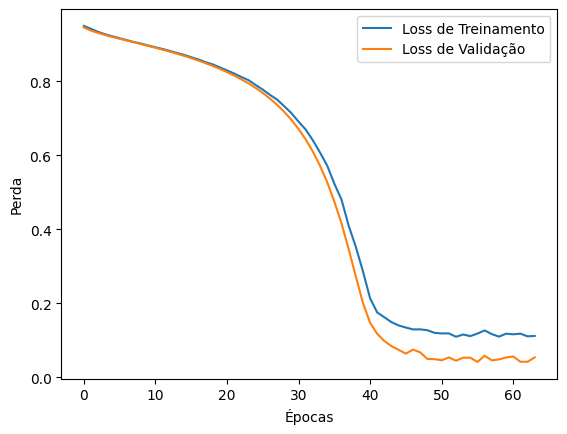

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0741
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


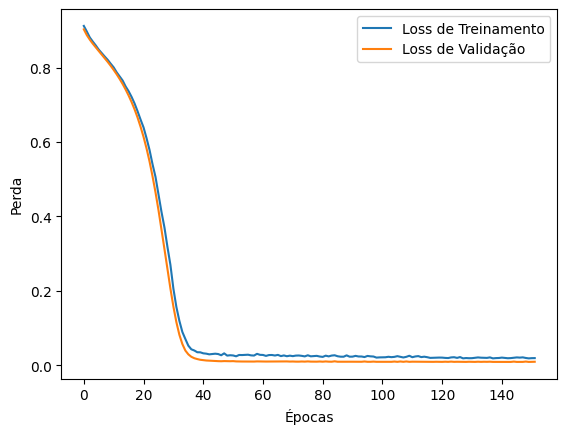

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


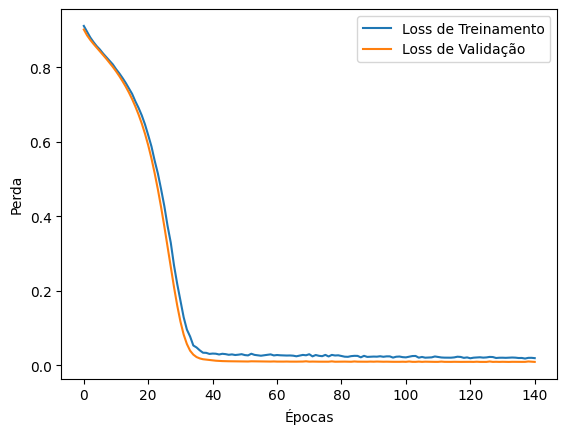

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


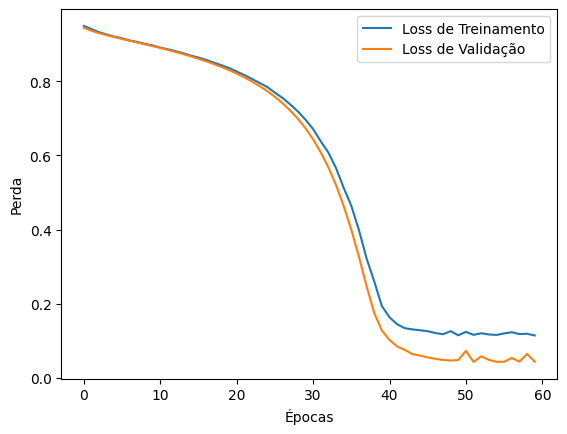

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0773
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


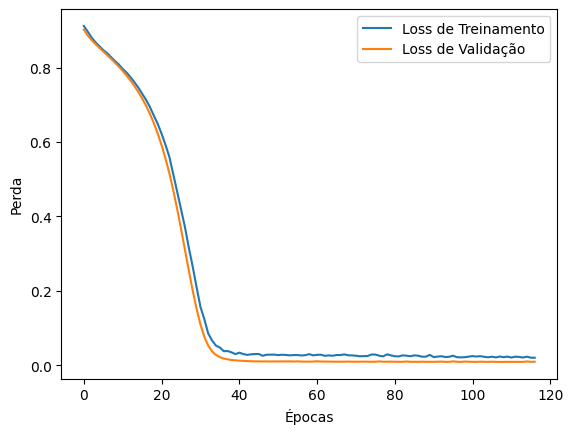

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0227
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


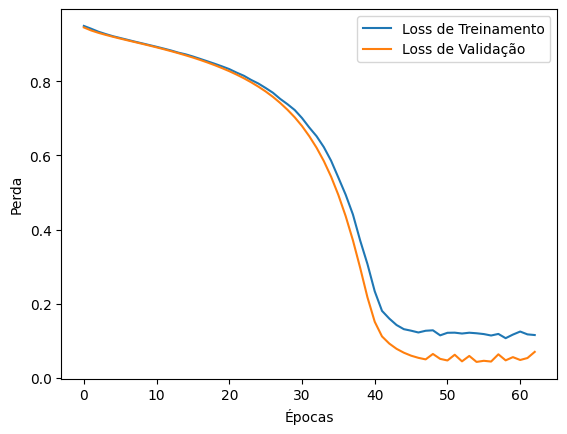

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


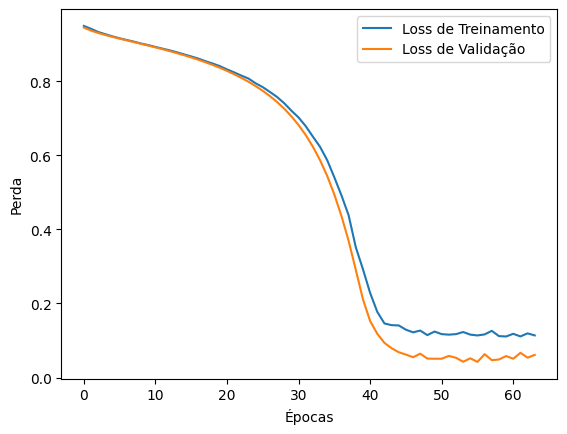

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0772
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


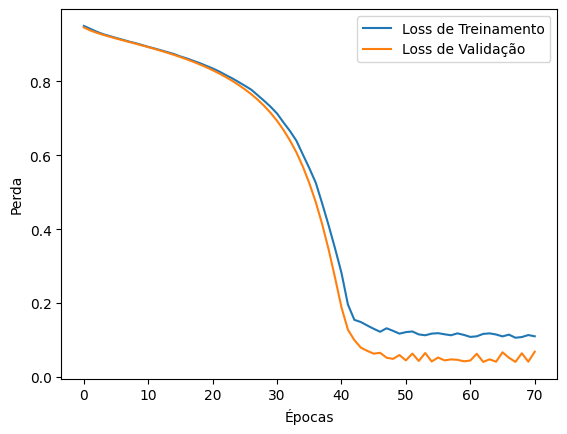

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0755
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


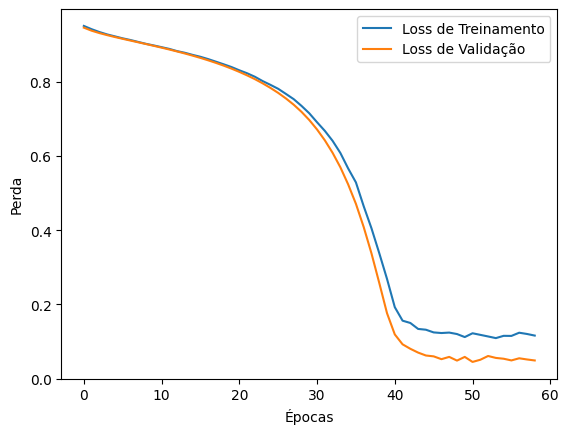

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0785
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss mean_squared_error
optimizer rmsprop


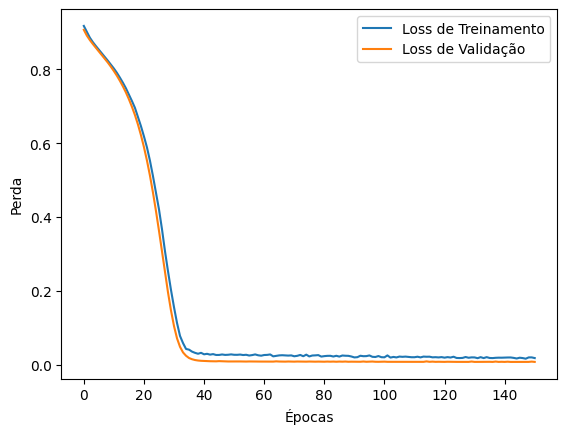

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0236
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


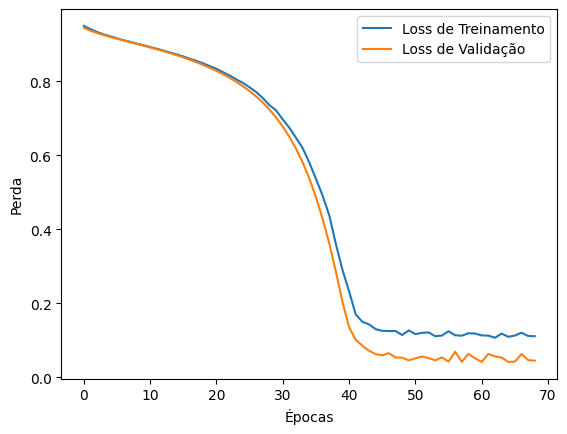

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0749
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


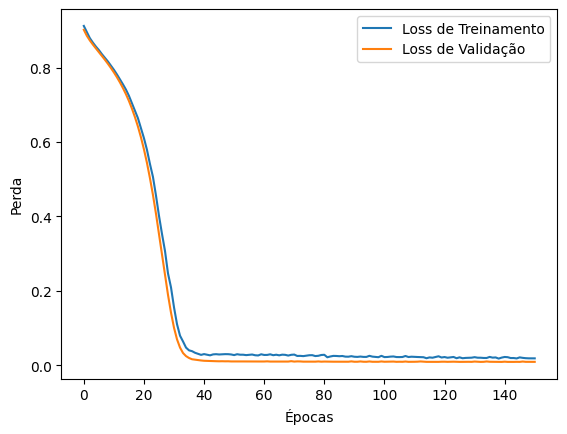

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0234
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


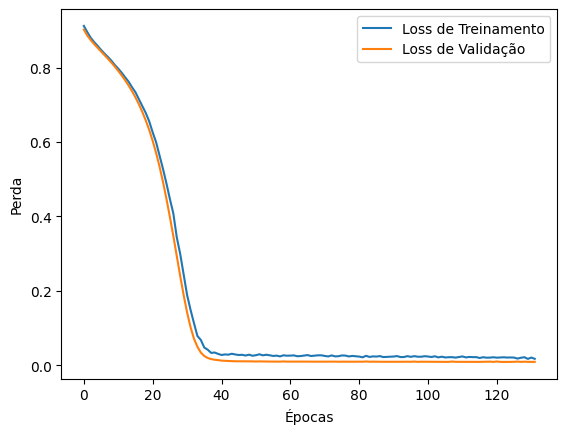

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0229
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


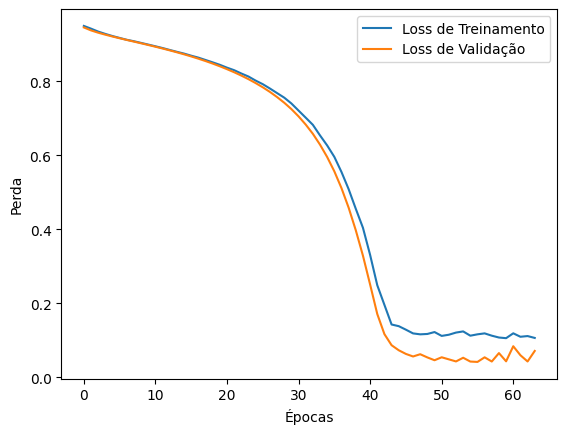

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


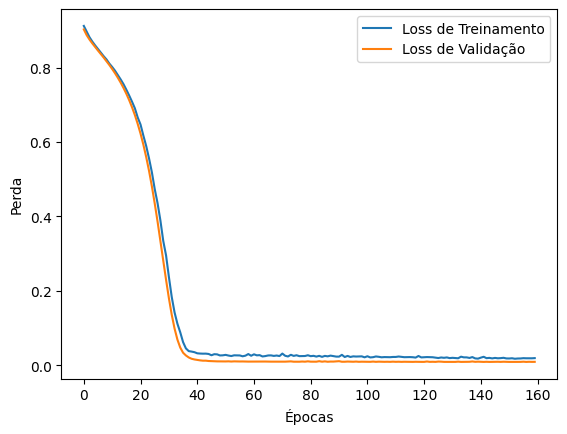

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0235
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


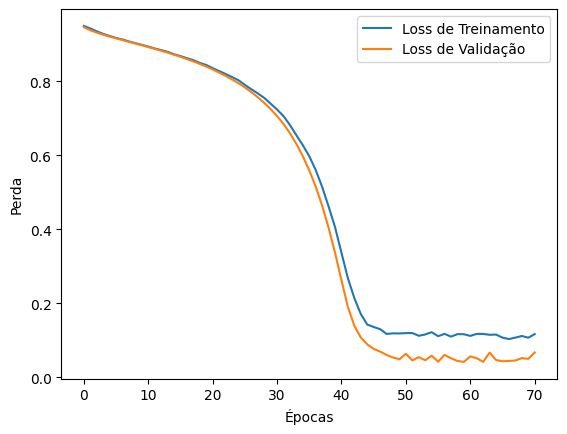

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0749
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


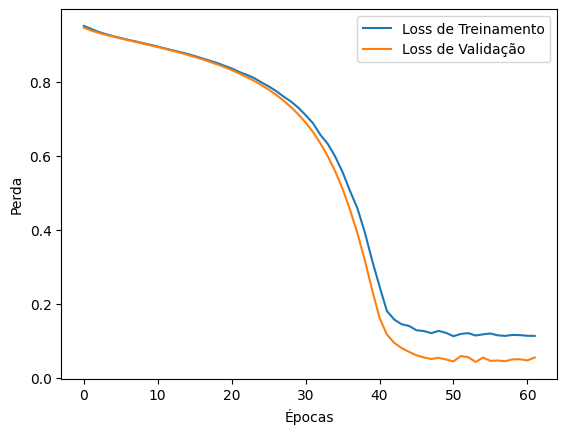

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0765
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


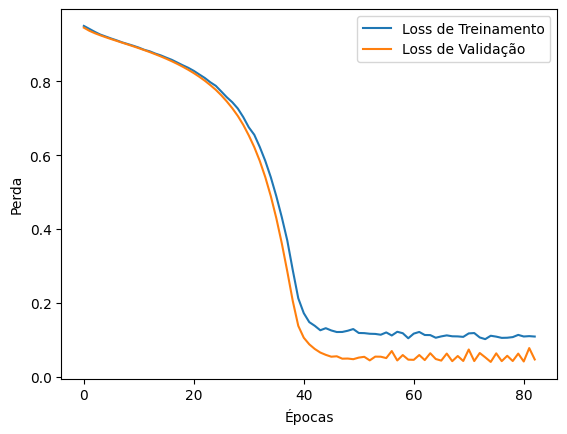

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0776
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


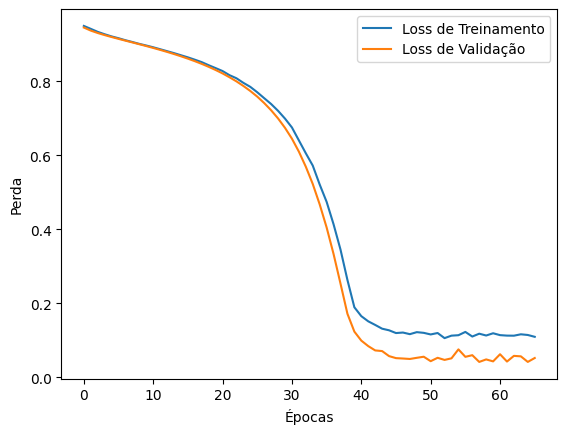

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0750
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


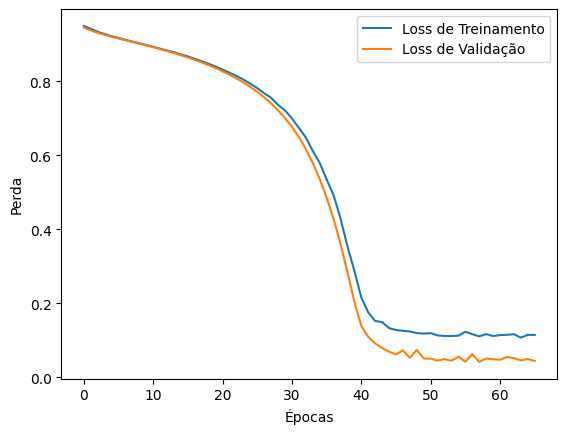

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


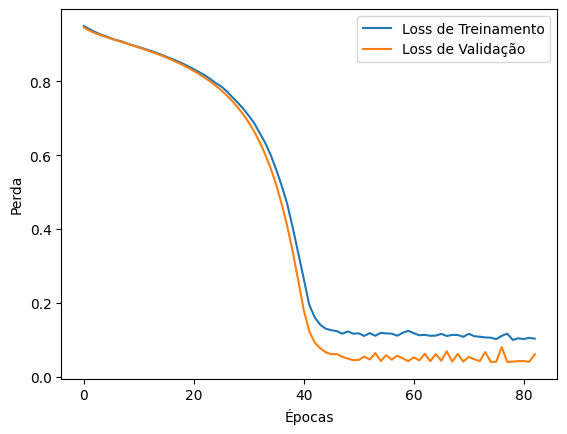

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0756
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


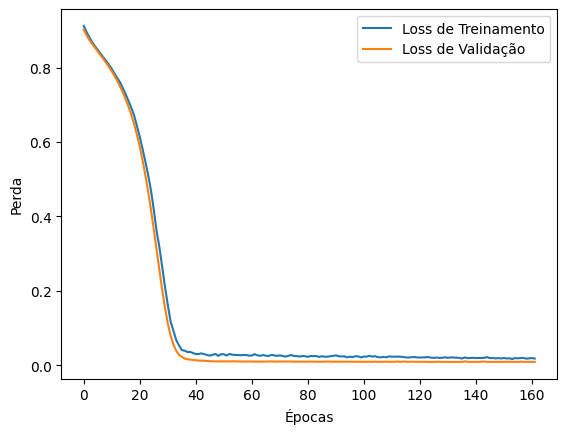

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0234
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


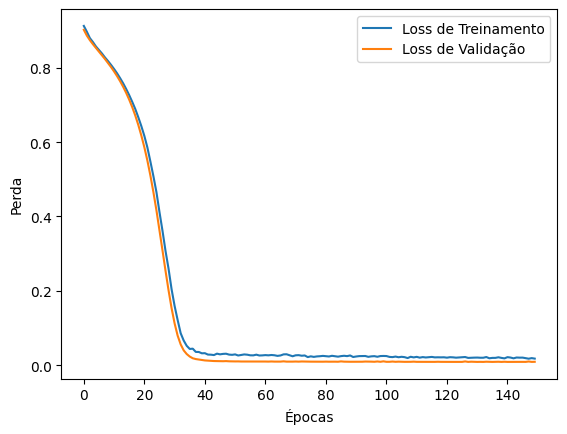

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


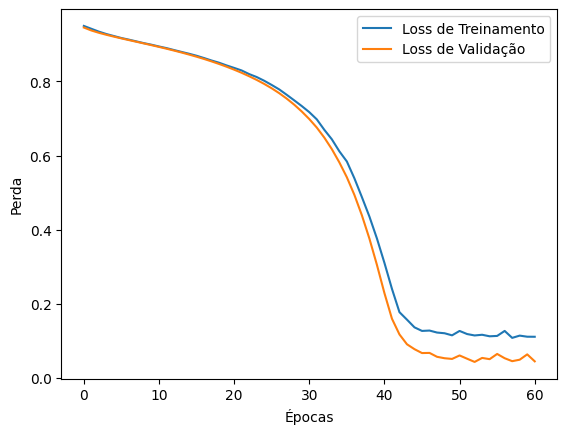

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0757
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


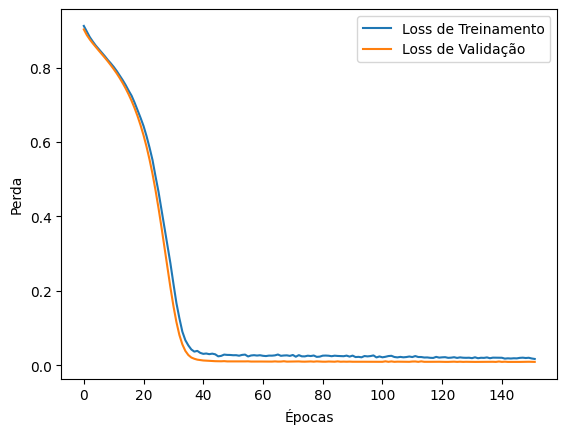

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0232
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


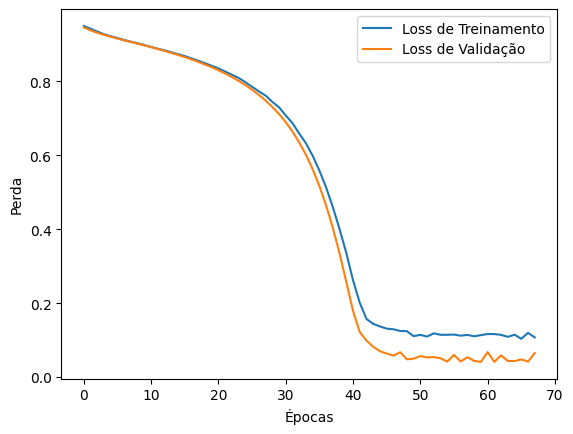

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


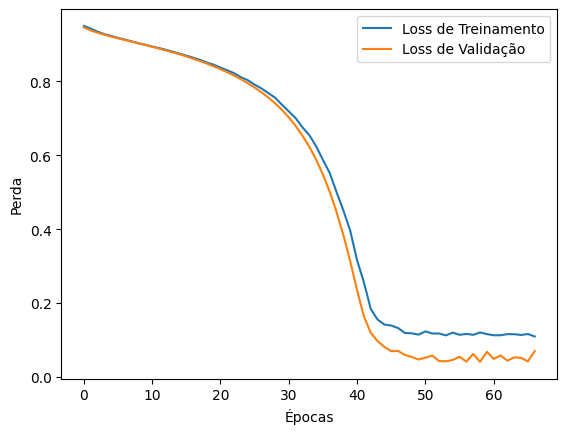

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


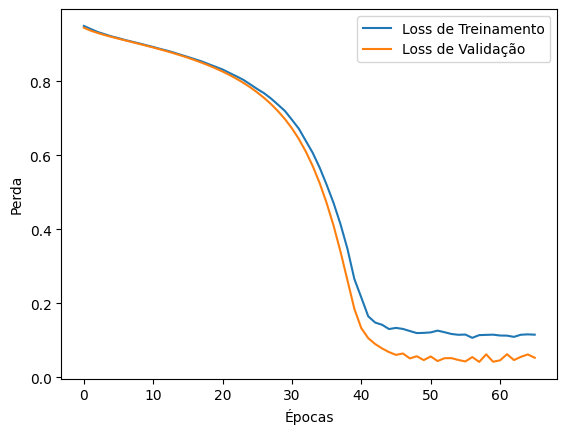

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0762
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


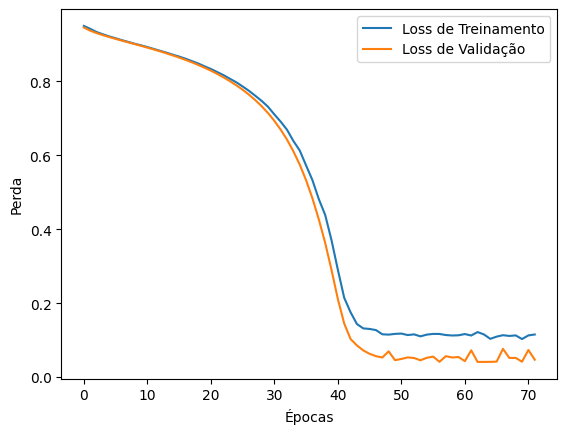

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0744
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


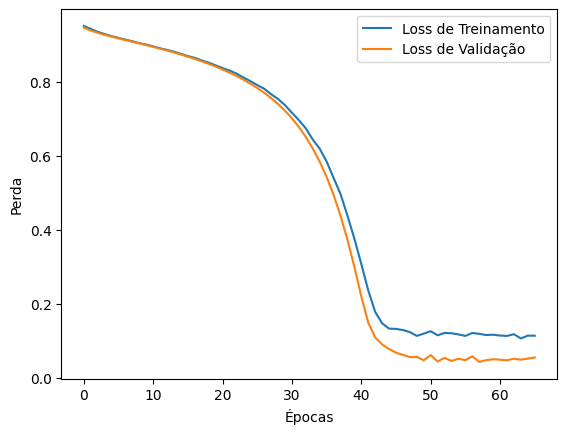

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0750
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


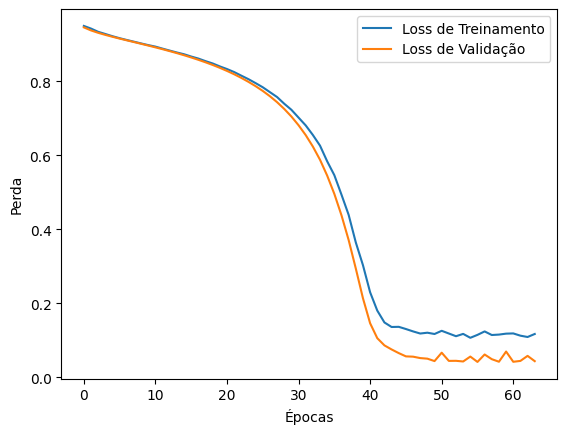

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


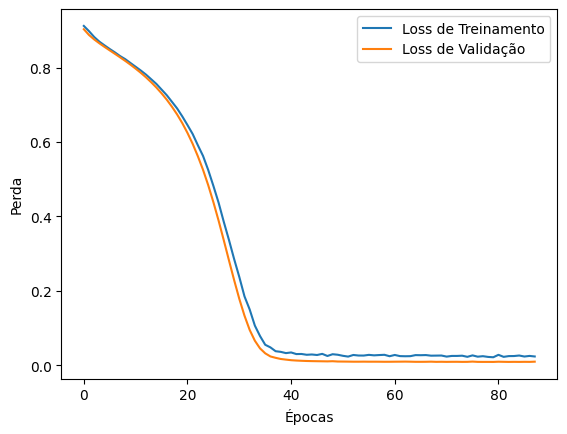

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0224
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


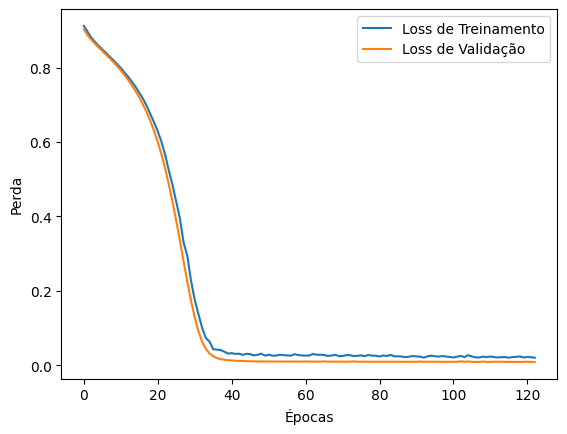

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0227
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


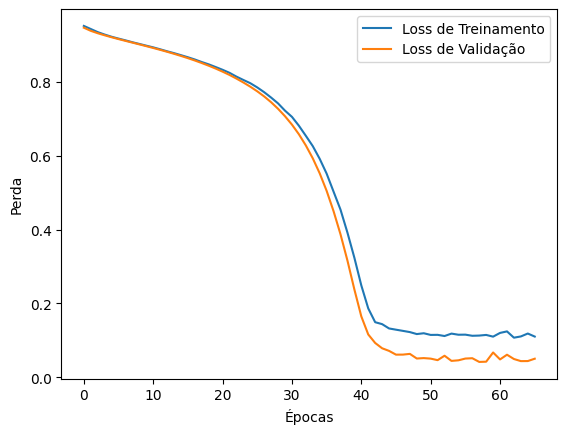

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


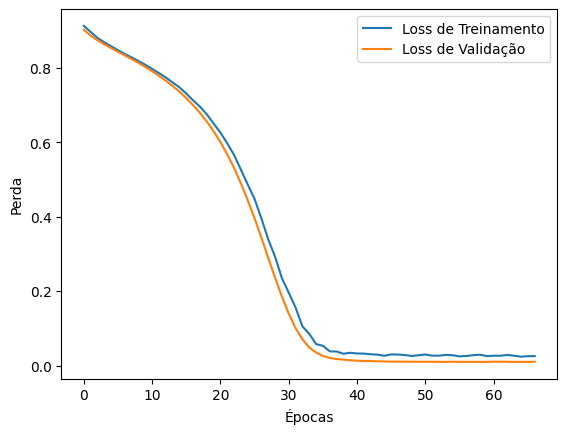

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0223
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


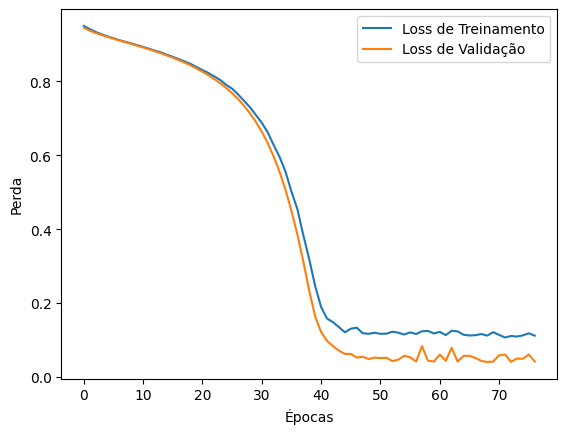

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0760
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


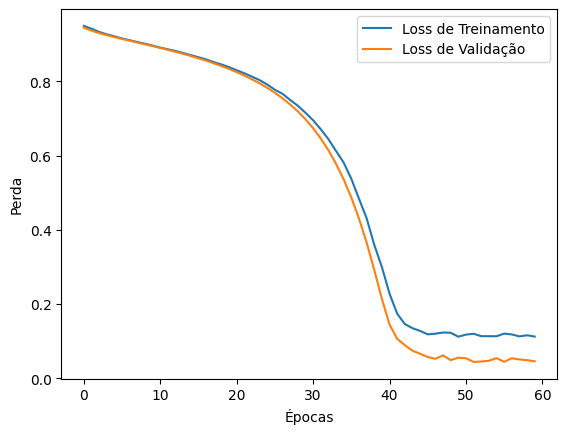

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0779
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


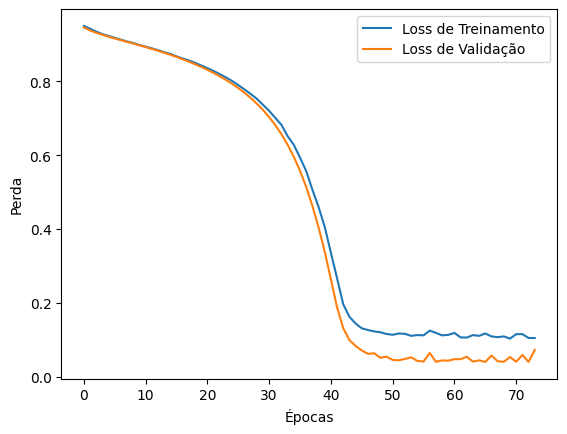

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0759
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


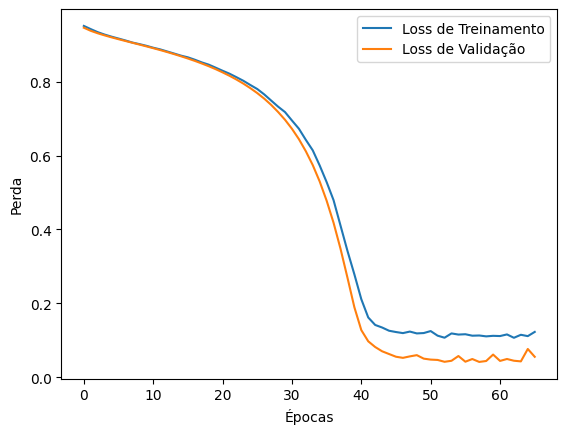

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0755
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


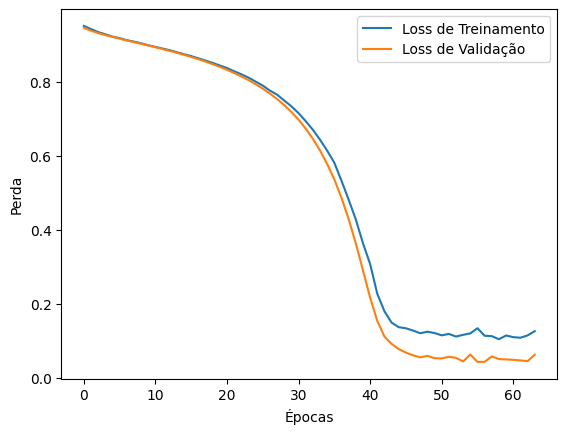

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


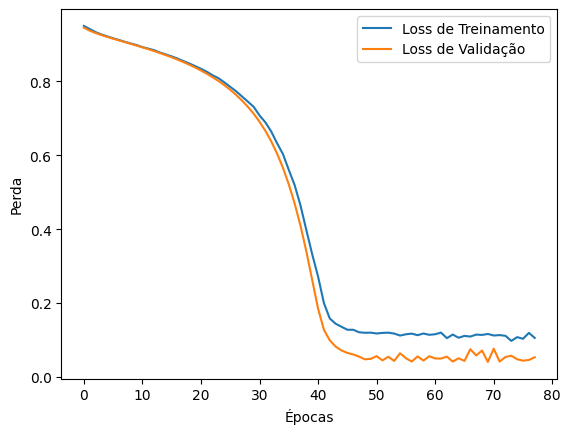

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0764
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


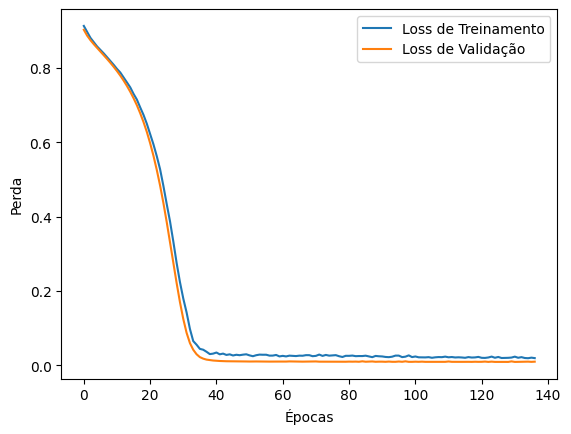

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


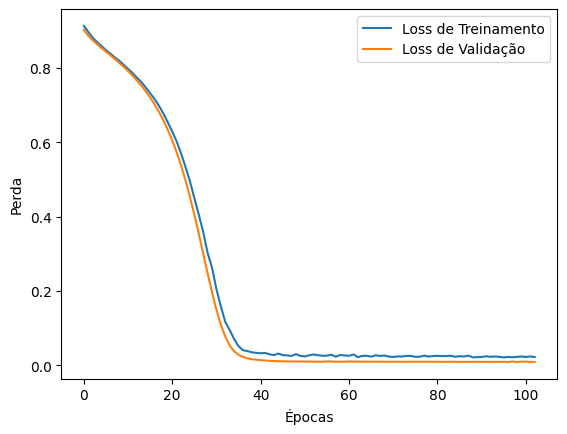

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0224
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


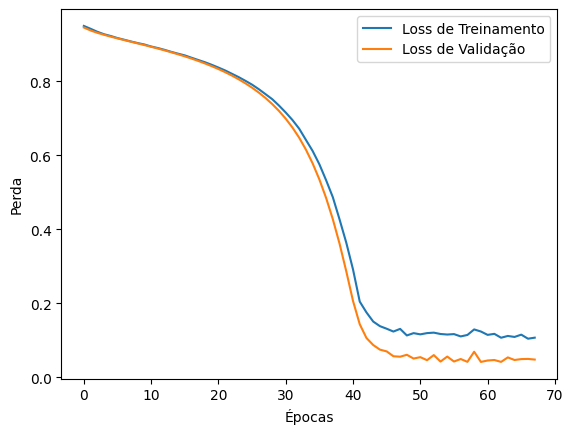

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0763
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


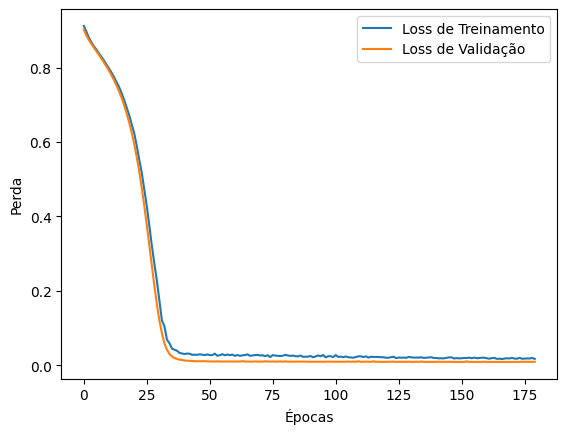

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0240
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


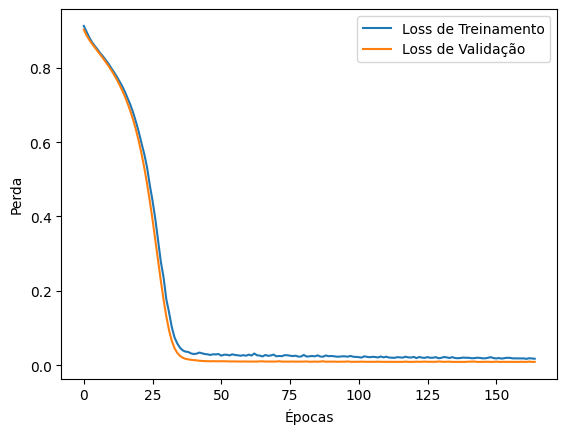

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0231
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


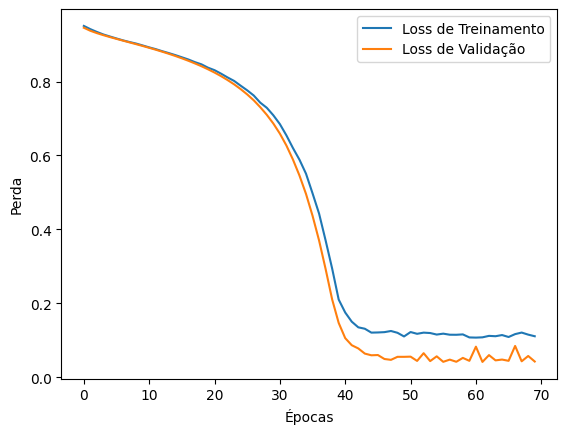

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0758
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


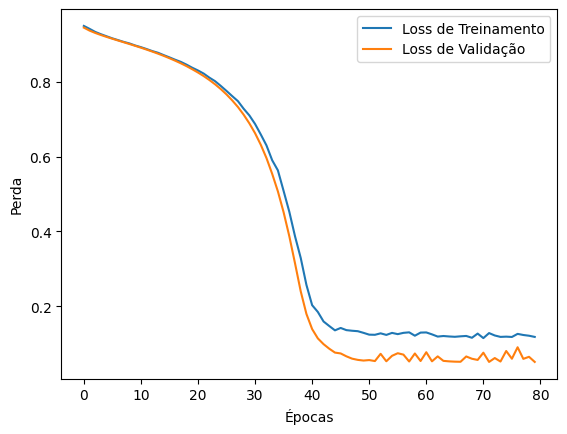

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0846
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


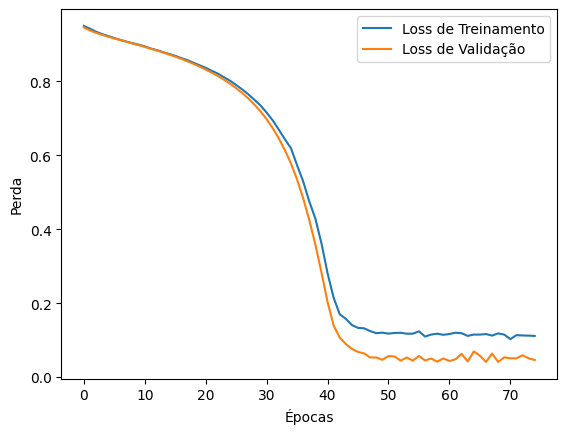

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0748
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


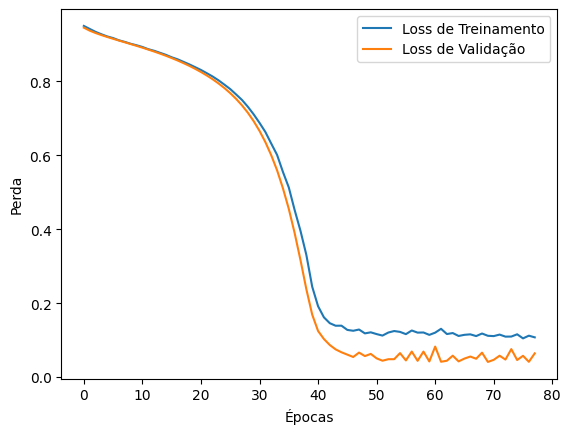

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0769
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


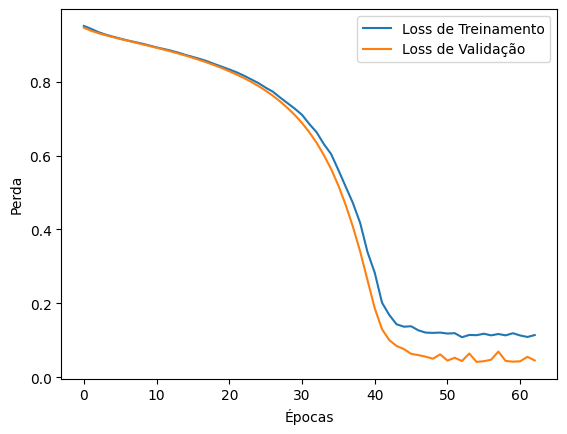

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0759
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


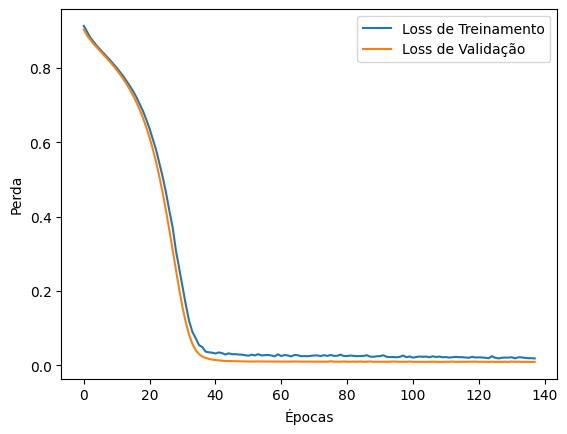

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0226
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


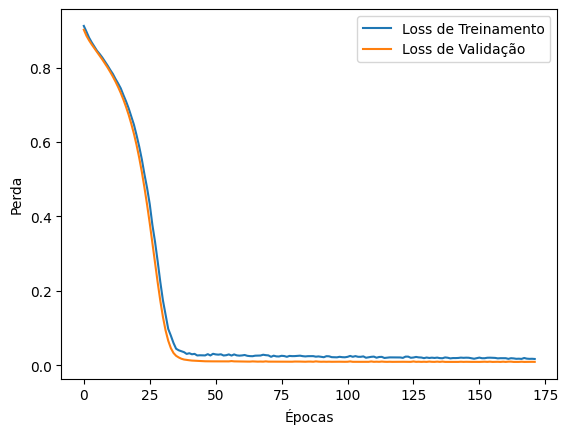

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0238
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


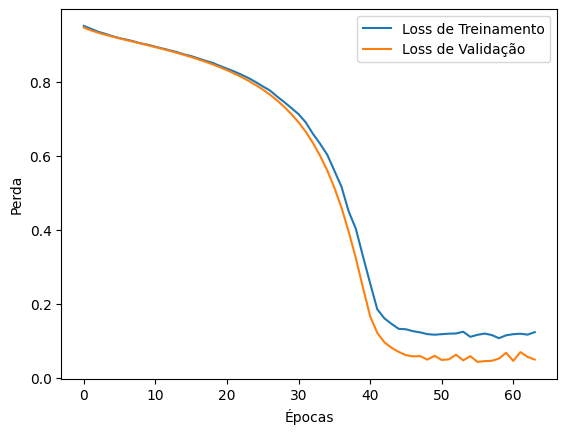

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0770
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


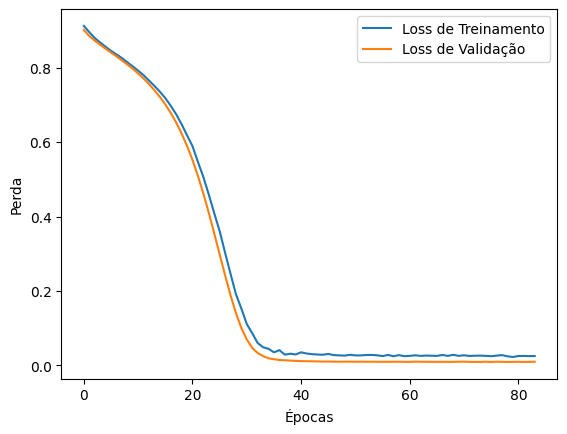

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0223
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


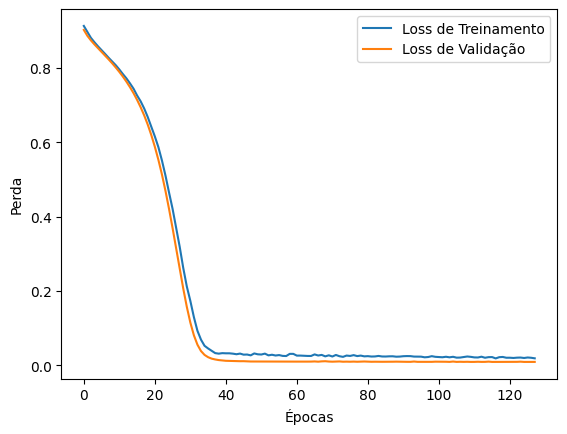

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0229
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


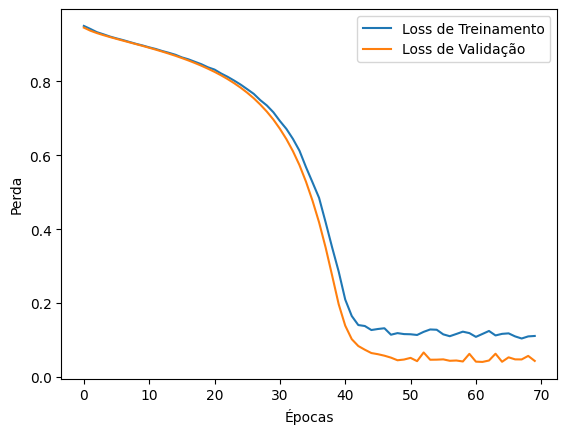

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0744
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


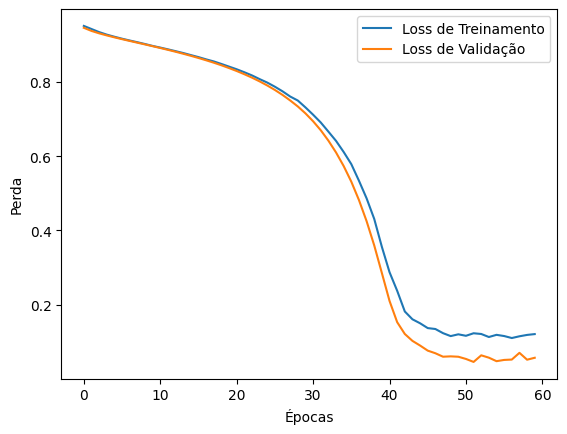

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0800
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


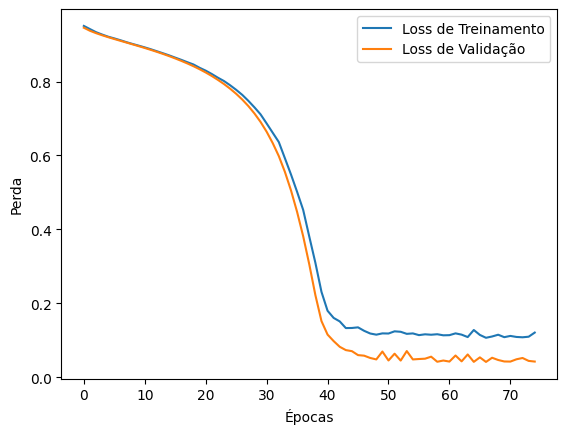

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0753
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


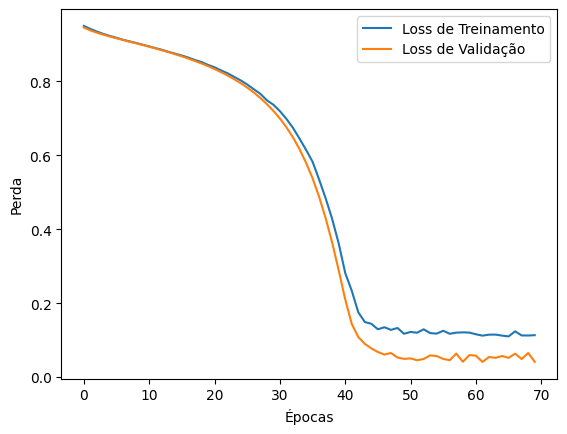

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0763
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


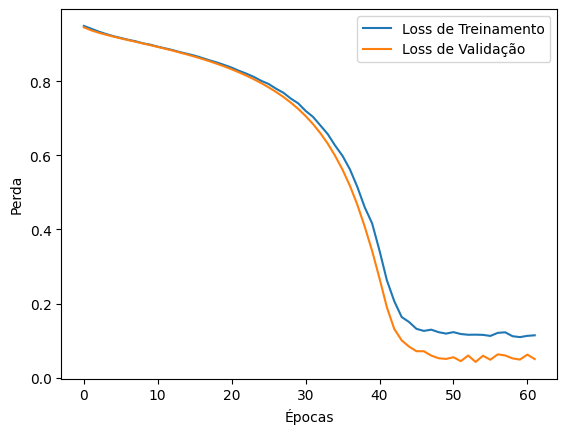

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0769
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


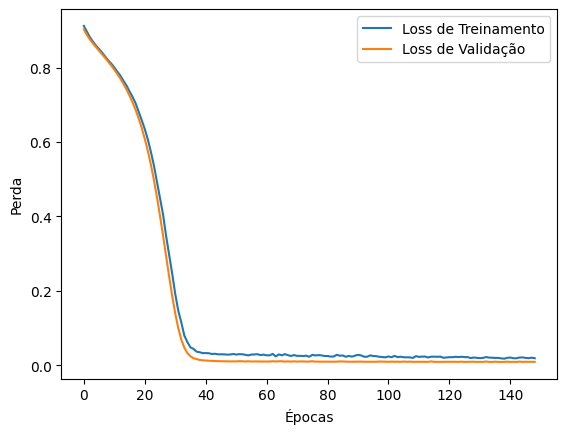

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0230
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmse at 0x000001698DFDEA70>
optimizer rmsprop


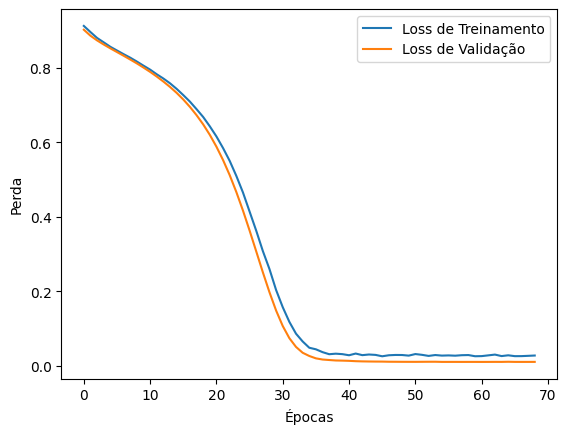

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0220
units 68
dropout_rate 0.3
learning_rate 0.0025
batch_size 113
patience 8
num_camadas_LSTM 3
activation relu
loss <function wmae at 0x000001698DFDEB00>
optimizer rmsprop


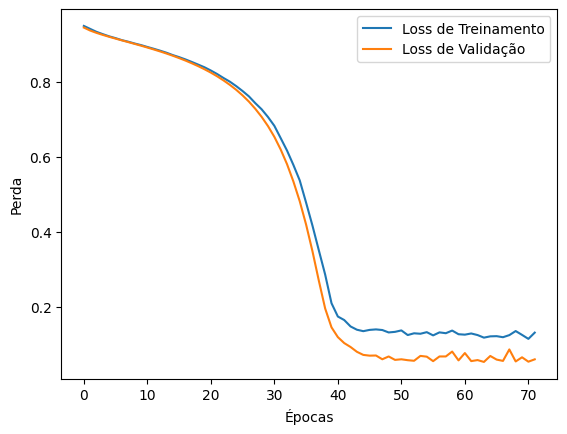

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0849
Melhor solução encontrada: [0.94931787]
Melhor score: 0.021921638399362564


In [ ]:
import numpy as np

# Definições para PSO
n_particles = 10   # Número de partículas (conjunto-candidato de hiperparâmetros) otimizadas por iteração
n_iterations = 20  # Número de vezes que o PSO otimiza as partículas
w = 0.5            # Inércia - controla a influência da velocidade anterior da partícula
c1 = 0.5           # Coeficiente cognitivo - controla a influência da melhor posição da partícula
c2 = 0.5           # Coeficiente social - controla a influência da melhor posição global

bounds = [(0, 3)]

# Inicialização das partículas
particles = np.random.rand(n_particles, len(bounds))                                                     
# Gera uma matriz de números aleatórios no intervalo [0,1). A matriz 
# tem dimensões n_particles - linhas e len(bounds) - colunas, sendo len(bounds)
# o número de hiperparâmetros sendo otimizados.
particles = particles * (np.array([ub - lb for lb, ub in bounds])) + np.array([lb for lb, ub in bounds]) 
# Cada linha de particles representa uma partícula, e cada coluna representa um valor correspondente a um hiperparâmetro.
# O primeiro np.array cria um array que contém a diferença entre o limite superior (ub)
# e o limite inferior (lb) de cada hiperparâmetro. Após isso, particles (definidas inicialmente entre [0,1))
# são multiplicadas pela amplitude de cada intervalo.
# O segundo np.array cria um array com os valores mínimos de cada hiperparâmetro. Esse array é somado ao primeiro array
# para garantir que todas as partículas terão seus hiperparâmetros dentro dos limites estabelecidos. 


velocities = np.random.rand(n_particles, len(bounds)) # Define as velocidades iniciais das partículas de forma aleatória
pbest_positions = particles.copy()                    # Guarda a melhor posição individual de cada partícula
pbest_scores = [float('inf')] * n_particles  # Inicialização com um valor alto
#pbest_scores = np.full(n_particles, np.inf)           # Inicializa os melhores scores individuais como infinito
gbest_position = None                                 # A melhor posição global encontrada por todas as partículas (inicialmente None)
gbest_score = np.inf                                  # O melhor score global, inicialmente infinito

# Função para atualizar a posição e a velocidade das partículas
# Ajusta as partículas para que se movam em direção à melhor solução encontrada até o momento, 
# tanto individualmente (pbest_positions) quanto globalmente (gbest_position).
def update_particles(particles, velocities):
    # particles - array com as posições atuais de todas as partículas
    # velocities - array com as velocidades atuais de todas as partículas
    for i in range(n_particles):            # Loop para atualizar todas as partículas
        velocities[i] = w * velocities[i] + c1 * np.random.rand() * (pbest_positions[i] - particles[i]) + c2 * np.random.rand() * (gbest_position - particles[i])
        # Atualiza a velocidade da partícula. W (inercia) multiplica a velocidade atual da partícula.
        # C1 (componente cognitiva) multiplica a diferença entre a melhor posição e a posição atual (da partícula).
        # np.random.rand() gera uma matriz de números aleatórios entre [0,1) para evitar que a partícula fique presa em uma trajetória fixa
        # C2 - (componente social) multiplica a diferença entre a melhor posição considerando todas as partículas
        # e a posição atual da partícula.        
        particles[i] += velocities[i]
        # A nova posição da partícula é atualizada somando a posição atual à nova velocidade
        # Move a partícula em direção à sua nova posição no espaço de soluções
        particles[i] = np.clip(particles[i], [lb for lb, ub in bounds], [ub for lb, ub in bounds])
        # np.clip garante que cada partícula permaneça dentro dos limites definidos em bounds para cada hiperparâmetro
        # np.clip(x, a, b) faz com que, se x for menor que a, ele se torne a, e se for maior que b, ele se torne b.

# Otimização
# O PSO irá atualizar as partículas e verificar as melhores soluções n_iterations vezes.
for iteration in range(n_iterations):
    # Para cada iteração todas as partículas são avaliadas: seu desempenho e ajuste de sua posição e velocidade
    for i in range(n_particles):
        score = fitness_function(particles[i])
        # Função que treina e testa o modelo com os hiperparâmetros da partícula atual
        # Cada partícula é avaliada através da sua posição/estado atual (valores-candidatos dos seus hiperparâmetros)
        # É retornado o erro que avalia quão boa é a posição atual

        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest_positions[i] = particles[i].copy()
        # Se o score for o melhor score pessoal da partícula, este valor e a posição (hiperparâmetros) são salvos
        # copy() é usado para garantir que uma nova instância da posição seja armazenada, evitando modificações acidentais.

        if score < gbest_score:
            gbest_score = score
            gbest_position = particles[i].copy()
            print(f"best_score_until_now", gbest_score)
            print("Melhor solução encontrada até agora:", gbest_position)
        # Se o score for o melhor score global de todas as partículas, este valor e a posição (hiperparâmetros) são salvos

    update_particles(particles, velocities)
    # Após a avaliação de todas as partículas e seus hiperparâmetros (dentro da mesma iteração), a função update_particles
    # é chamada para atualizar as posições das partículas (hiperparâmetros) com base nos resultados da iteração atual 

print("Melhor solução encontrada:", gbest_position)
print("Melhor score:", gbest_score)


In [16]:
print("Melhor solução encontrada:", gbest_position)
print("Melhor score:", gbest_score)

Melhor solução encontrada: [0.94931787]
Melhor score: 0.021921638399362564
